In [ ]:
# in this notebook, I will try to fit a model relating the mean behavior of L4, L2/3, SST and VIP cells

In [ ]:
# load the data

In [1]:
import pyute as ut
import autograd.numpy as np
import matplotlib.pyplot as plt
import sklearn
import h5py
import pdb
import scipy.optimize as sop
from mpl_toolkits.mplot3d import Axes3D
import sklearn.discriminant_analysis as skd
import autograd.scipy.special as ssp
from autograd import elementwise_grad as egrad
from autograd import grad
from autograd import jacobian
from autograd import hessian
import size_contrast_analysis as sca
import scipy.stats as sst
import sim_utils
from importlib import reload
reload(sim_utils)
import calnet.utils
import calnet.fitting_spatial_feature_opto
import calnet.calnet as cc
import opto_utils
import glob
import scipy.signal as ssi
import calnet.fitting_multiout_callable as fmc
%matplotlib notebook

/Users/dan/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [2]:
npfile = np.load('rs_vm_denoise_200605.npy',allow_pickle=True)[()]#,{'rs':rs,'rs_denoise':rs_denoise},allow_pickle=True)
rs = npfile['rs']
rs_denoise = npfile['rs_denoise']

In [3]:
npydict = np.load('../shared_data/calnet_data/W0list.npy',allow_pickle=True)[()]
W10list = npydict['W10list']
W20list = npydict['W20list']
bd1list = npydict['bd1list']
bd2list = npydict['bd2list']
freeze_vals = npydict['freeze_vals']
bounds1 = npydict['bounds1']

In [4]:
W10list[6:8]

[array([[ 0.27545763, -0.09704203, -0.43532622,  0.02497212],
        [ 0.38574037,  0.49778656, -0.43667839,  0.14618986]]),
 array([[-0.0295094 ,  0.085316  , -0.18985851,  0.35156556],
        [-0.09058742,  0.22949787, -0.29769366,  0.01620939],
        [-0.20297831,  0.20247919,  0.22415415, -0.03355502],
        [ 0.17075259,  0.41950613, -0.21155527, -0.07123098]])]

In [5]:
nP,nQ = 2,4

In [6]:
bd1list[6]

array([[-1.5,  0. , -1.5, -1.5],
       [-1.5, -1.5, -1.5, -1.5]])

<IPython.core.display.Javascript object>


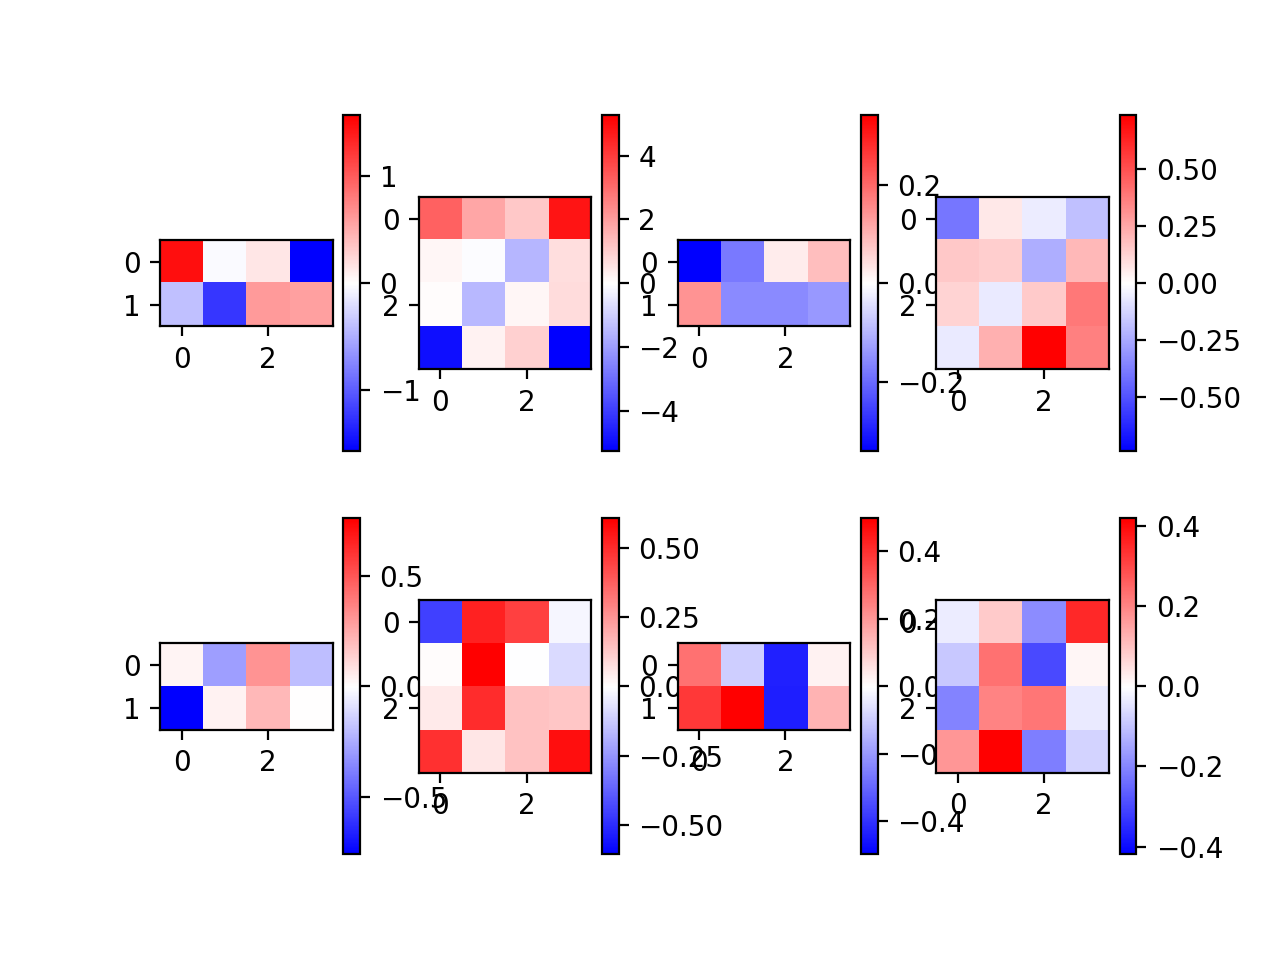

<IPython.core.display.Javascript object>


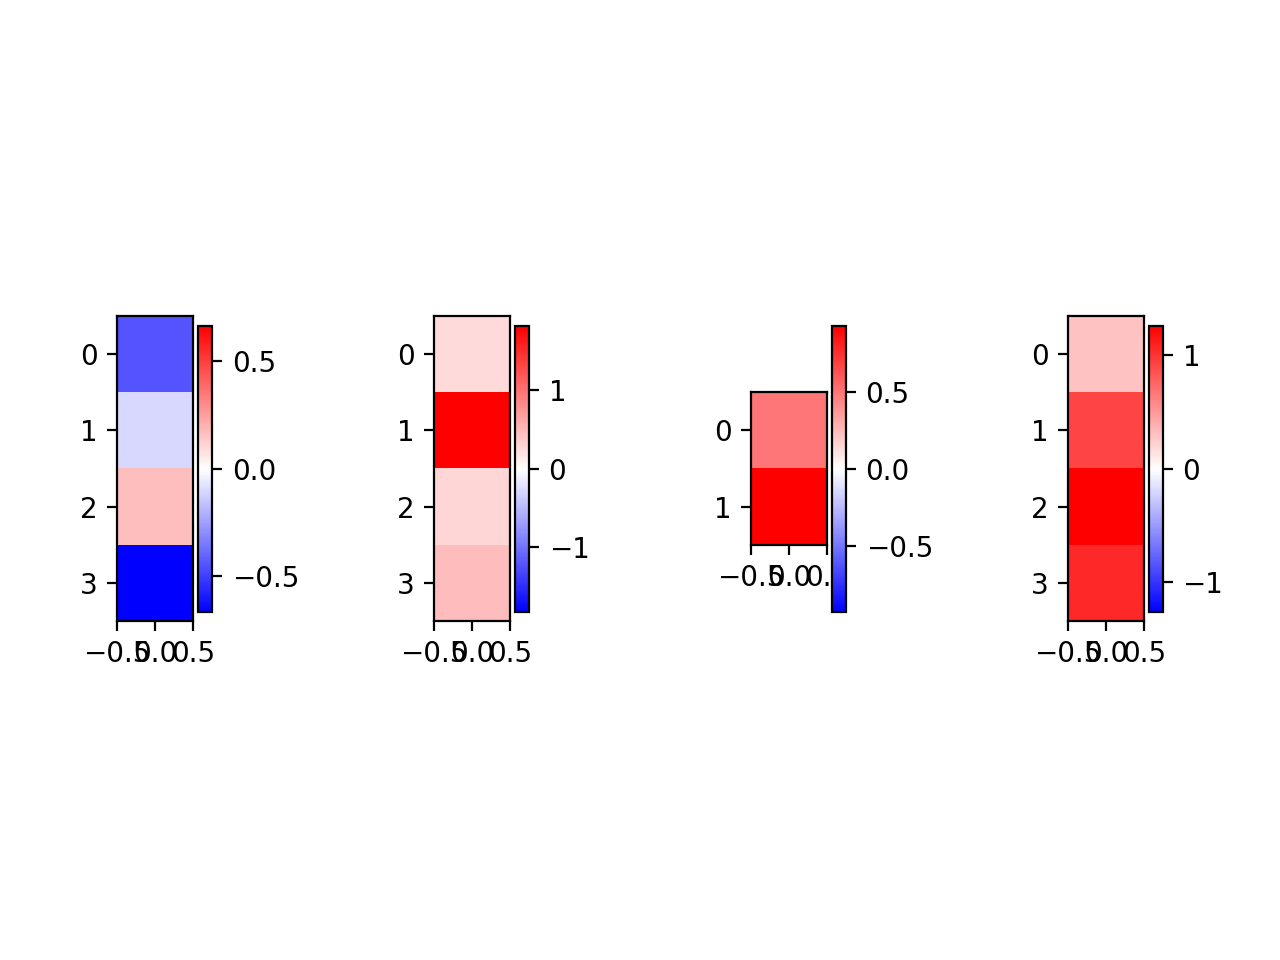

<IPython.core.display.Javascript object>


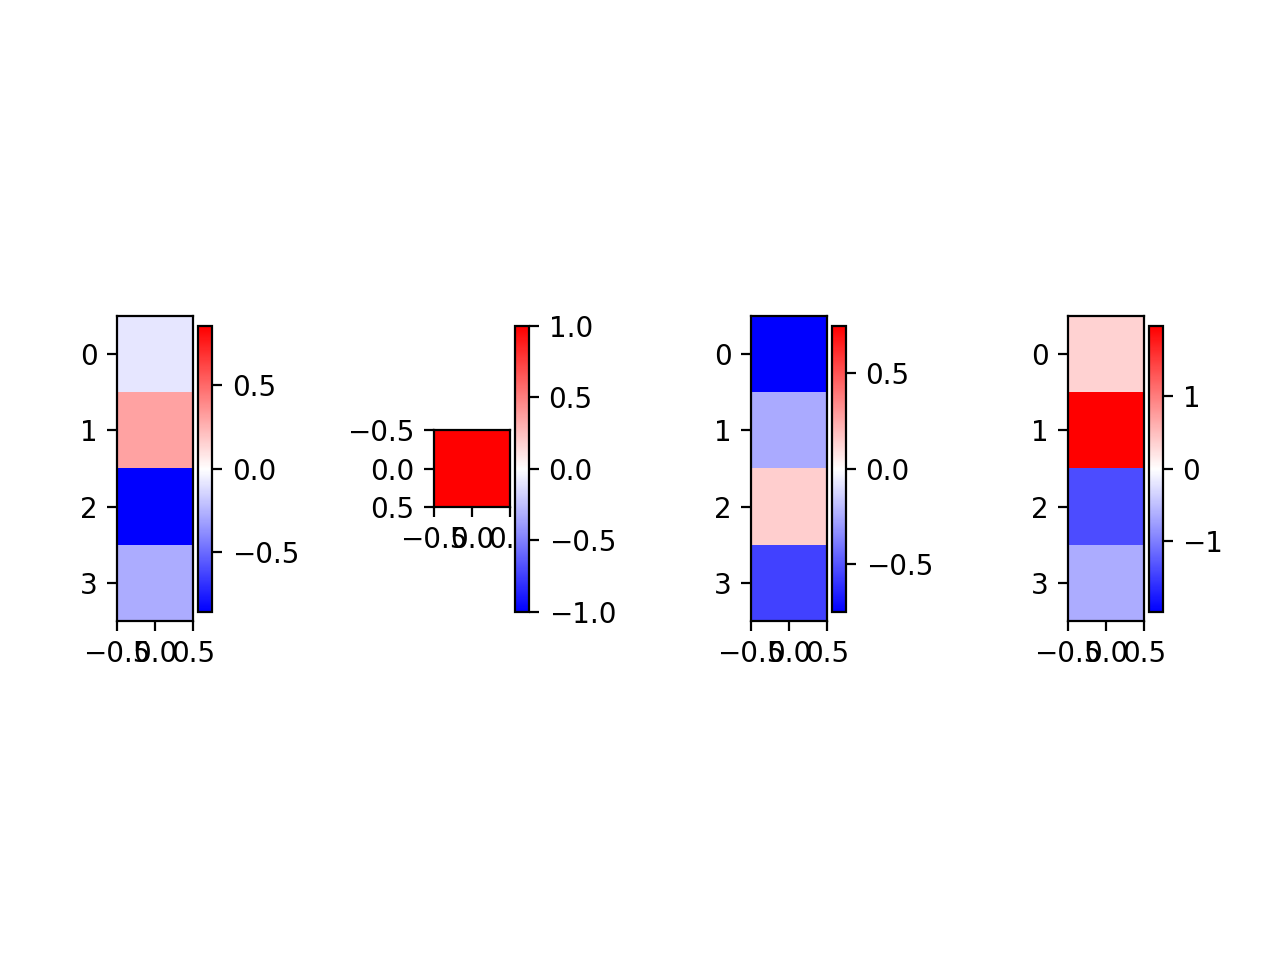

In [7]:
plt.figure()
for ivar in range(8):
    plt.subplot(2,4,ivar+1)
    ut.imshow_hot_cold(W10list[ivar])
    plt.colorbar()
plt.figure()
for ivar in range(4):
    plt.subplot(1,4,ivar+1)
    ut.imshow_hot_cold(W10list[9+ivar][:,np.newaxis])
    plt.colorbar()
plt.tight_layout()
plt.figure()
for ivar in range(4):
    plt.subplot(1,4,ivar+1)
    ut.imshow_hot_cold(W10list[14+ivar][:,np.newaxis])
    plt.colorbar()
plt.tight_layout()

In [87]:
# plt.figure()
for ivar in range(4):
#     plt.subplot(1,4,ivar+1)
#     plt.imshow(W20list[ivar])
#     plt.colorbar()
    print(W20list[ivar].shape)

(41, 8)
(41, 8)
(41, 16)
(41, 16)


In [8]:
nsize,ncontrast,ndir = 6,6,8
ori_dirs = [[0,4],[2,6]] #[[0,4],[1,3,5,7],[2,6]]
nT = len(ori_dirs)
nS = len(rs_denoise[0])

def sum_to_1(r):
    R = r.reshape((r.shape[0],-1))
    R = R/np.nansum(R[:,~np.isnan(R.sum(0))],axis=1)[:,np.newaxis]
    return R

def norm_to_mean(r):
    R = r.reshape((r.shape[0],-1))
    R = R/np.nanmean(R[:,~np.isnan(R.sum(0))],axis=1)[:,np.newaxis]
    return R

Rs = [[None,None] for i in range(len(rs))]
Rso = [[[None for iT in range(nT)] for iS in range(nS)] for icelltype in range(len(rs))]
rso = [[[None for iT in range(nT)] for iS in range(nS)] for icelltype in range(len(rs))]

for iR,r in enumerate(rs):#_denoise):
    print(iR)
    for ialign in range(nS):
        Rs[iR][ialign] = sum_to_1(r[ialign][:,:nsize,:])
#         Rs[iR][ialign] = von_mises_denoise(Rs[iR][ialign].reshape((-1,nsize,ncontrast,ndir)))

kernel = np.ones((1,2,2))
kernel = kernel/kernel.sum()

for iR,r in enumerate(rs):
    for ialign in range(nS):
        for iori in range(nT):
            Rso[iR][ialign][iori] = np.nanmean(Rs[iR][ialign].reshape((-1,nsize,ncontrast,ndir))[:,:,:,ori_dirs[iori]],-1)
            Rso[iR][ialign][iori][:,:,0] = np.nanmean(Rso[iR][ialign][iori][:,:,0],1)[:,np.newaxis]
            Rso[iR][ialign][iori][:,1:,1:] = ssi.convolve(Rso[iR][ialign][iori],kernel,'valid')
            Rso[iR][ialign][iori] = Rso[iR][ialign][iori].reshape(Rso[iR][ialign][iori].shape[0],-1)

0
1
2
3
4


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)


In [9]:
nS = 2
nT = 2
ndims = 5
ncelltypes = 5
Yhat = [[None for iT in range(nT)] for iS in range(nS)]
Xhat = [[None for iT in range(nT)] for iS in range(nS)]
Ypc_list = [[None for iT in range(nT)] for iS in range(nS)]
Xpc_list = [[None for iT in range(nT)] for iS in range(nS)]
for iS in range(nS):
    mx = np.zeros((ncelltypes,))
    yy = [None for icelltype in range(ncelltypes)]
    for icelltype in range(ncelltypes):
        yy[icelltype] = np.nanmean(Rso[icelltype][iS][0],0)
        mx[icelltype] = np.nanmax(yy[icelltype])
    for iT in range(nT):
        y = [np.nanmean(Rso[icelltype][iS][iT]/mx[icelltype],axis=0)[:,np.newaxis] for icelltype in range(1,ncelltypes)]#
        Ypc_list[iS][iT] = [None for icelltype in range(1,ncelltypes)]
        for icelltype in range(1,ncelltypes):
            print((icelltype,iS,iT))
            rss = np.concatenate(Rso[icelltype][iS],axis=1) #.reshape(Rs[icelltype][ialign].shape[0],-1)
            rss = rss[np.isnan(rss).sum(1)==0]
    #         print(rss.max())
    #         rss[rss<0] = 0
    #         rss = rss[np.random.randn(rss.shape[0])>0]
            try:
                u,s,v = np.linalg.svd(rss-np.mean(rss,0)[np.newaxis])
                if iT == 0:
                    Ypc_list[iS][iT][icelltype-1] = [(s[idim],v[idim,:nN]) for idim in range(ndims)]
                else:
                    Ypc_list[iS][iT][icelltype-1] = [(s[idim],v[idim,nN:]) for idim in range(ndims)]
#                 print('yep on Y')
#                 print(np.min(np.sum(rs[icelltype][iS][iT],axis=1)))
            except:
#                 print('nope on Y')
                print(np.mean(np.isnan(rss)))
                print(np.min(np.sum(rs[icelltype][iS][iT],axis=1)))
        Yhat[iS][iT] = np.concatenate(y,axis=1)
#         x = sim_utils.columnize(Rso[0][iS][iT])[:,np.newaxis]
        icelltype = 0
        x = np.nanmean(Rso[icelltype][iS][iT]/mx[icelltype],0)[:,np.newaxis]#/mx[icelltype]
#         opto_column = np.concatenate((np.zeros((nN,)),np.zeros((nNO/2,)),np.ones((nNO/2,))),axis=0)[:,np.newaxis]
        Xhat[iS][iT] = np.concatenate((x,np.ones_like(x)),axis=1)
#         Xhat[iS][iT] = np.concatenate((x,np.ones_like(x),opto_column),axis=1)
        icelltype = 0
        rss = Rso[icelltype][iS][iT].copy()
        rss = rss[np.isnan(rss).sum(1)==0]
#         try:
        u,s,v = np.linalg.svd(rss-rss.mean(0)[np.newaxis])
        Xpc_list[iS][iT] = [None for iinput in range(2)]
        Xpc_list[iS][iT][0] = [(s[idim],v[idim]) for idim in range(ndims)]
        Xpc_list[iS][iT][1] = [(0,np.zeros((Xhat[0][0].shape[0],))) for idim in range(ndims)]
#         except:
#             print('nope on X')
#             print(np.mean(np.isnan(rss)))
#             print(np.min(np.sum(Rso[icelltype][iS][iT],axis=1)))
nN,nP = Xhat[0][0].shape
nQ = Yhat[0][0].shape[1]

(1, 0, 0)
0.0
nan
(2, 0, 0)
0.0
nan
(3, 0, 0)
0.0
nan
(4, 0, 0)
0.0
0.14974558240334904
(1, 0, 1)
0.0
nan
(2, 0, 1)
0.0
nan
(3, 0, 1)
0.0
nan
(4, 0, 1)
0.0
0.15014062815212778
(1, 1, 0)
0.0
nan
(2, 1, 0)
0.0
nan
(3, 1, 0)
0.0
nan
(4, 1, 0)
0.0
0.1256780429144523
(1, 1, 1)
0.0
nan
(2, 1, 1)
0.0
nan
(3, 1, 1)
0.0
nan
(4, 1, 1)
0.0
0.06810146852928613


In [10]:
def compute_f_(Eta,Xi,s02):
    return sim_utils.f_miller_troyer(Eta,Xi**2+np.concatenate([s02 for ipixel in range(nS*nT)]))

def compute_fprime_m_(Eta,Xi,s02):
    return sim_utils.fprime_miller_troyer(Eta,Xi**2+np.concatenate([s02 for ipixel in range(nS*nT)]))*Xi

def compute_fprime_s_(Eta,Xi,s02):
    s2 = Xi**2+np.concatenate((s02,s02),axis=0)
    return sim_utils.fprime_s_miller_troyer(Eta,s2)*(Xi/s2)

def sorted_r_eigs(w):
    drW,prW = np.linalg.eig(w)
    srtinds = np.argsort(drW)
    return drW[srtinds],prW[:,srtinds]

# def gen_Weight(W,K,kappa):
#     WW0 = np.concatenate((W,W*K[np.newaxis,:]),axis=1)
#     WW1 = np.concatenate((W*K[np.newaxis,:]*kappa,W),axis=1)
#     WW = np.concatenate((WW0,WW1),axis=0)
#     return WW

def u_fn(XX,YY,Wx,Wy,k,kappa):
    WWx,WWy = [gen_Weight(W,k,kappa) for W in [Wx,Wy]]
    return u_fn_WW(XX,YY,WWx,WWy)# XX @ WWx + YY @ WWy

def u_fn_WW(XX,YY,WWx,WWy):
    return XX @ WWx + YY @ WWy

def compute_steady_state(Wlist,Niter=int(4e2),max_val=2.5,Ny=50,fix_dim=None,stim_vals=None,dt=1e-2,perturbation_size=5e-2):
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wlist
    nQ = Wmy.shape[0]
    nN = Eta.shape[0]
    nS = int(Eta.shape[1]/nQ)
    
    if fix_dim is None:
        fix_dim = [None]
        Nfix = 1
        yvals = (0,)
        Ny = 1
        max_val = 0
    else:
        Nfix = len(fix_dim)
        yvals = np.linspace(0,max_val,Ny)
    
    if stim_vals is None:
        stim_vals = np.arange(nN)
    Nstim = len(stim_vals)
    
    fval = compute_f_(Eta,Xi,s02)
    resEta = Eta - u_fn(XX,fval,Wmx,Wmy,k,kappa)
    resXi = Xi - u_fn(XX,fval,Wsx,Wsy,k,kappa)
    
    def fY(XX,YY):
        return compute_f_(resEta[stim_val]+u_fn(XX,YY,Wmx,Wmy,k,kappa),resXi[stim_val]+u_fn(XX,YY,Wsx,Wsy,k,kappa),s02)
    def predict_YY_fix_dim(XX,YY0,fix_dim=None,run_backward=False,):
        def dYYdt(YY):
            return -YY + fY(XX,YY)
        YY = np.zeros((Niter+1,nS*nQ))
        YY[0] = YY0 #np.zeros((nN,nS*nQ))
        dYY = np.zeros_like(YY[0])
        iiter = 0
        while iiter < Niter: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            dYY = dt*dYYdt(YY[iiter])
            if not fix_dim is None:
                dYY[fix_dim] = 0
            if run_backward:
                dYY = -dYY
            YY[iiter+1] = YY[iiter] + dYY
            iiter = iiter+1
        return YY
    
    YY_ss = np.zeros((Nfix,Nstim,Ny,Niter+1,nS*nQ))
    YY0 = compute_f_(Eta,Xi,s02)
    for istim,stim_val in enumerate(stim_vals): #range(nN):
        print(istim)
        for iy,yval in enumerate(yvals):
            for ifix in range(Nfix):
                yy0 = YY0[stim_val] + perturbation_size*np.random.randn(*(YY0[stim_val].shape))
                if not fix_dim[ifix] is None:
                    yy0[fix_dim[ifix]] = yval
                YY_ss[ifix,istim,iy] = predict_YY_fix_dim(XX[stim_val],yy0,fix_dim=fix_dim[ifix])
    if fix_dim[0] is None:
        YY_ss = YY_ss[0,:,0,:,:]
    return YY_ss

In [11]:
npyfile = np.load('/Users/dan/Documents/notebooks/mossing-PC/shared_data/calnet_data/vip_halo_data_for_sim.npy',allow_pickle=True)[()]
Yhat_opto = npyfile['Yhat_opto']

In [12]:
YYhat = calnet.fitting_spatial_feature_opto.flatten_nested_list_of_2d_arrays(Yhat)
XXhat = calnet.fitting_spatial_feature_opto.flatten_nested_list_of_2d_arrays(Xhat)

In [13]:
    def gen_Weight(W,K,kappa,T):
        MuT = np.array((1,2,1))
        MuK = np.array((1,kappa))
        WT = circulate(W,T,nT,Mu=MuT)
        KKlist = [K for iT in range(nT)]
        KK = np.concatenate(KKlist,axis=0)
        WW = circulate(WT,KK,nS,Mu=MuK)
        return WW

In [14]:
    def circulate(V,M,nZ,Mu=None):
        Vpartlist = [V*(M[np.newaxis,:]**np.abs(iZ)) for iZ in range(-nZ+1,nZ)]
        if Mu is None:
            Mu = np.ones((nZ,))
        #VVlist = [np.concatenate([m*v for m,v in zip(Mu,Vpartlist[nZ-iZ-1:2*nZ-iZ-1])],axis=1) for iZ in range(nZ)]
        VVlist = [np.concatenate(Vpartlist[nZ-iZ-1:2*nZ-iZ-1],axis=1) for iZ in range(nZ)]
        #VV = np.concatenate(VVlist,axis=0)
        VV = np.concatenate([m*v for m,v in zip(Mu,VVlist)],axis=0)
        return VV

In [100]:
basefold = '/Users/dan/Documents/notebooks/mossing-PC/shared_data/calnet_data/'
# subfold = 'weights_200901i/'
# subfold = 'weights_200131b/'
subfold = 'weights_210423a/'
# subfold = 'weights_210405a/'
plots_fold = basefold + 'fit_graphics/' + subfold
ut.mkdir(plots_fold)
weights_fold = basefold + 'weights/' + subfold
weights_files = glob.glob(weights_fold+'*.npy')
weights_files.sort()
# weights_filenames = [s.split('/')[-1][:-4] for s in weights_files]


In [101]:
weights_files

['/Users/dan/Documents/notebooks/mossing-PC/shared_data/calnet_data/weights/weights_210423a/015.npy',
 '/Users/dan/Documents/notebooks/mossing-PC/shared_data/calnet_data/weights/weights_210423a/025.npy']

In [102]:
losses = np.array([np.load(wf,allow_pickle=True)[()]['loss'] for wf in weights_files])

In [103]:
losses

array([481.21056434, 410.30999797])

In [104]:
lkat = (losses < 500)#np.nanpercentile(losses,20))

In [105]:
lkat.sum()

2

In [106]:
reload(fmc)

opt = fmc.gen_opt_axon(nondim=True)

# def u_fn(XX,YY,Wx,Wy,k,kappa,T):
#     WWx,WWy = [gen_Weight(W,k,kappa,T) for W in [Wx,Wy]]
#     return u_fn_WW(XX,YY,WWx,WWy)# XX @ WWx + YY @ WWy

# def u_fn_WW(XX,YY,WWx,WWy):
#     return XX @ WWx + YY @ WWy

def colorful_scatter(a,b):
    for icelltype in range(ncelltypes-1):
        plt.scatter(a[:,icelltype],b[:,icelltype],s=10)

for weights_file in weights_files:
    plt.close('all')
    Wstar_dict = np.load(weights_file,allow_pickle=True)[()]
#     Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi,h1,h2 = Wstar_dict['as_list']
    W0x,W0y,W1x,W1y,W2x,W2y,W3x,W3y,s02,K0,K1,K2,K3,kappa,T0,T1,T2,T3,XX,XXp,Eta,Xi,h1,h2,bl,amp = Wstar_dict['as_list']
    W1,W2 = fmc.W1_W2_from_list(Wstar_dict['as_list'])
    weights_filename = weights_file.split('/')[-1][:-4]

    XXhat = np.concatenate([np.concatenate(x,axis=1) for x in Xhat],axis=1)
    YYhat = np.concatenate([np.concatenate(x,axis=1) for x in Yhat],axis=1)
    YY = compute_f_(Eta,Xi,s02)
    YYp = compute_fprime_m_(Eta,Xi,s02)
    u0,u1,u2,u3 = fmc.compute_us(W1,W2,YY,YYp,opt)
    Etastar = u0 + u2
    Xistar = u1 + u3
    YYstar = compute_f_(Etastar,Xistar,s02)
    nrows = 3
    ncols = 2
    plt.figure(1,figsize=(2*ncols,2*nrows))
    plt.subplot(nrows,ncols,1)
    colorful_scatter(YYhat,YY)
    plt.xlabel('Measured Y')
    plt.ylabel('Modeled Y')
    plt.plot((0,1),(0,1),c='k')
    plt.subplot(nrows,ncols,2)
    plt.scatter(XXhat,XX,s=10)
    plt.xlabel('Measured X')
    plt.ylabel('Modeled X')
    plt.plot((0,1),(0,1),c='k')
    plt.subplot(nrows,ncols,3)
    colorful_scatter(Eta,Etastar)
    plt.xlabel('Modeled input current')
    plt.ylabel('Self-consistent input current')
    lim = np.max(np.abs(Etastar))
    plt.plot((-lim,lim),(-lim,lim),c='k')
    plt.subplot(nrows,ncols,4)
    colorful_scatter(Xi,Xistar)
    plt.xlabel('Modeled input current var')
    plt.ylabel('Self-consistent input current var')
    lim = np.max(np.abs(Xistar))
    plt.plot((-lim,lim),(-lim,lim),c='k')
    plt.subplot(nrows,ncols,5)
    colorful_scatter(YY,YYstar)
    plt.xlabel('Modeled Y')
    plt.ylabel('Self-consistent Y')
    plt.plot((0,1),(0,1),c='k')
    plt.subplot(nrows,ncols,6)
    colorful_scatter(YYhat,YYstar)
    plt.xlabel('Measured Y')
    plt.ylabel('Self-consistent Y')
    plt.plot((0,1),(0,1),c='k')
    plt.tight_layout()
#     plt.savefig(plots_fold+weights_filename+'.jpg',dpi=300)

ValueError: too many values to unpack (expected 26)

In [ ]:
WW3.shape

In [123]:
reload(calnet.utils)
reload(fmc)
nP,nQ = 3,4
nS,nT = 2,2
nN = 92
opt = fmc.gen_opt_axon(nondim=True,nN=nN,nP=nP,nQ=nQ,nS=nS,nT=nT)
nfiles = len(weights_files)
Ts = [np.zeros((nfiles,nQ)) for _ in range(2)]
Txs = [np.zeros((nfiles,nP)) for _ in range(2)]
Tys = [np.zeros((nfiles,nQ)) for _ in range(2)]
Ks = [np.zeros((nfiles,nQ)) for _ in range(2)]
Kxs = [np.zeros((nfiles,nP)) for _ in range(2)]
Kys = [np.zeros((nfiles,nQ)) for _ in range(2)]
Wys = [np.zeros((nfiles,nQ,nQ)) for _ in range(4)]
Wxs = [np.zeros((nfiles,nP,nQ)) for _ in range(4)]
Etas = np.zeros((nfiles,nN,nQ*nS*nT))
Xis = np.zeros((nfiles,nN,nQ*nS*nT))
XXs = np.zeros((nfiles,nN,nP*nS*nT))
XXps = np.zeros((nfiles,nN,nP*nS*nT))
resEtas = np.zeros((nfiles,nN,nQ*nS*nT))
resXis = np.zeros((nfiles,nN,nQ*nS*nT))
couplings = np.zeros((nfiles,nN,nQ*nS*nT,nQ*nS*nT))
Xcouplings = np.zeros((nfiles,nN,nP*nS*nT,nQ*nS*nT))
nalpha = 9
WWsums = np.zeros((nfiles,(nP+nQ)*nS*nT,nQ*nS*nT,nalpha,nalpha))
for iwt,weights_file in enumerate(weights_files):
    Wstar_dict = np.load(weights_file,allow_pickle=True)[()]
    W0x,W0y,W1x,W1y,W2x,W2y,W3x,W3y,W0xrun,W0yrun,s02,Kin0,Kin1,Kxout0,Kyout0,Kxout1,Kyout1,kappa,Tin0,Tin1,Txout0,Tyout0,Txout1,Tyout1,XX,XXp,Eta,Xi,h1,h2,bl,amp = Wstar_dict['as_list']
    W1 = fmc.unparse_W(W0x,W0y,W1x,W1y,W2x,W2y,W3x,W3y,s02,Kin0,Kin1,Kxout0,Kyout0,Kxout1,Kyout1,kappa,Tin0,Tin1,Txout0,Tyout0,Txout1,Tyout1,h1,h2,bl,amp)
    W2 = fmc.unparse_W(XX,XXp,Eta,Xi)
    WWlist = fmc.compute_WWs(W1,opt)
    WW0,WW1,WW2,WW3 = WWlist
    
    rg = slice(None)#[0,1,2,3]
    alphas = np.linspace(-2,2,nalpha)
    WWsums[iwt] = WW0[:,rg,np.newaxis,np.newaxis] \
+ alphas[np.newaxis,np.newaxis,np.newaxis,:]*WW1[:,rg,np.newaxis,np.newaxis] \
+ alphas[np.newaxis,np.newaxis,:,np.newaxis]*WW2[:,rg,np.newaxis,np.newaxis] \
+ alphas[np.newaxis,np.newaxis,np.newaxis,:]*alphas[np.newaxis,np.newaxis,:,np.newaxis]*WW3[:,rg,np.newaxis,np.newaxis] 

    
#     WW0y = calnet.utils.gen_Weight_in_out_k_kappa_t(W0y,Kin0,Kyout0,kappa,Tin0,Tyout0,power=True)
#     WW0x = calnet.utils.gen_Weight_in_out_k_kappa_t(W0x,Kin0,Kxout0,kappa,Tin0,Txout0,power=True)
    Etas[iwt] = Eta
    Xis[iwt] = Xi
    XXs[iwt] = XX
    XXps[iwt] = XXp
    
    YY,YYp = fmc.compute_f_fprime_t_avg_(W1,W2,0,burn_in=0.5,max_dist=1,opt=opt)
    u0,u1,u2,u3 = fmc.compute_us_in_out(W1,W2,YY,YYp,opt)
    resEtas[iwt] = Eta - u0 - u2
    resXis[iwt]  = Xi - u1 - u3

    tiled_s02 = np.tile(s02,nS*nT)
    these_Ts = [Tin0,Tin1]
    these_Txs = [Txout0,Txout1]
    these_Tys = [Tyout0,Tyout1]
    these_Ks = [Kin0,Kin1]
    these_Kxs = [Kxout0,Kxout1]
    these_Kys = [Kyout0,Kyout1]
    these_Wys = [W0y,W1y,W2y,W3y]
    these_Wxs = [W0x,W1x,W2x,W3x]
    for ivar in range(4):
        Wys[ivar][iwt] = these_Wys[ivar]
        Wxs[ivar][iwt] = these_Wxs[ivar]
    for ivar in range(2):
        Ts[ivar][iwt] = these_Ts[ivar]
        Txs[ivar][iwt] = these_Txs[ivar]
        Tys[ivar][iwt] = these_Tys[ivar]
        Ks[ivar][iwt] = these_Ks[ivar]
        Kxs[ivar][iwt] = these_Kxs[ivar]
        Kys[ivar][iwt] = these_Kys[ivar]
#     for istim in range(nN):
#         Phi = np.diag(calnet.utils.fprime_miller_troyer(Eta[istim],Xi[istim]**2+tiled_s02))
#         couplings[iwt,istim] = Phi @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phi)
#         Xcouplings[iwt,istim] = WWmx @ Phi @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phi)

<IPython.core.display.Javascript object>


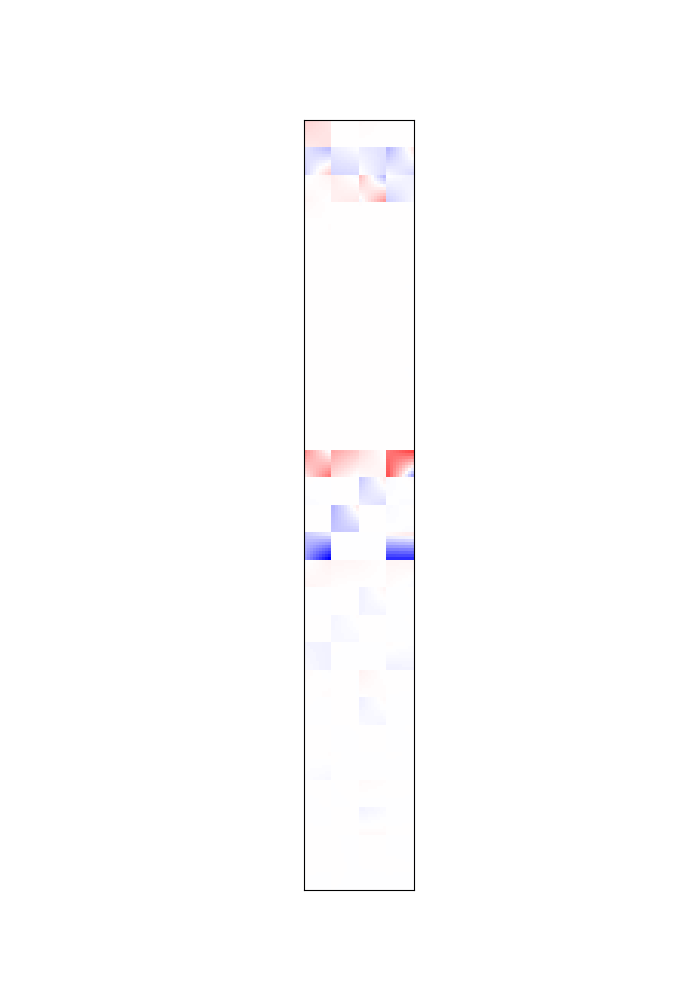

([], <a list of 0 Text yticklabel objects>)

In [127]:
rg = slice(None,4)#[0,1,2,3]
# alphas = np.linspace(-2,2,5)

plt.figure(figsize=(7,10))

# WWsum = WW0[:,rg,np.newaxis,np.newaxis] \
# + alphas[np.newaxis,np.newaxis,np.newaxis,:]*WW1[:,rg,np.newaxis,np.newaxis] \
# + alphas[np.newaxis,np.newaxis,:,np.newaxis]*WW2[:,rg,np.newaxis,np.newaxis] \
# + alphas[np.newaxis,np.newaxis,np.newaxis,:]*alphas[np.newaxis,np.newaxis,:,np.newaxis]*WW3[:,rg,np.newaxis,np.newaxis] 

rg = slice(None,4)
WWsum = np.nanmean(WWsums[lkat,:,rg],0)

WWsumr = WWsum.transpose((0,2,1,3)).reshape((WWsum.shape[0]*WWsum.shape[2],WWsum.shape[1]*WWsum.shape[3]))

ut.imshow_hot_cold(WWsumr)
plt.xticks(())
plt.yticks(())
# plt.yticks(np.arange(WWsumr.shape[0]))
# plt.ylim((WWsumr.shape[0]-0.5,-0.5))

In [151]:
reload(fmc)
ca_data_file = '../shared_data/calnet_data/rs_sc_fg_ret_pval_0_05_210423.npy'
pdim = 0
XXhat,YYhat,XXphat,YYphat = fmc.load_Rs_mean_cov(ca_data_file=ca_data_file,fit_running=True,fit_non_running=True,\
                                                 fit_sc=True,fit_fg=True,fit_ret=True,foldT=False,pdim=pdim)


In [147]:
XXs.shape

(2, 92, 12)

<IPython.core.display.Javascript object>


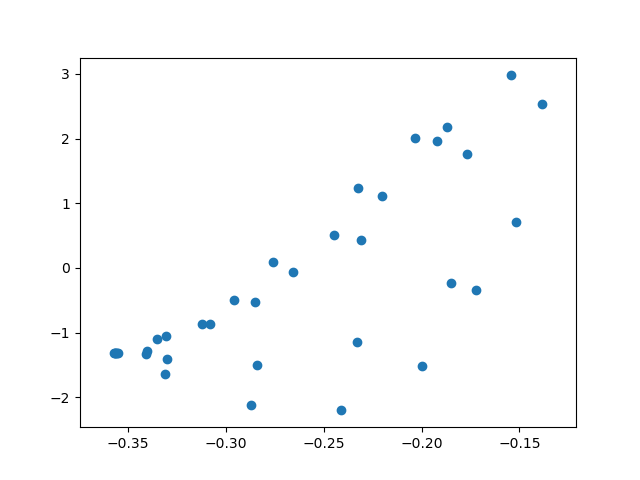

In [131]:
plt.figure()
plt.scatter(XXs[0,:36,0],XXs[0,36:72,0])

<IPython.core.display.Javascript object>


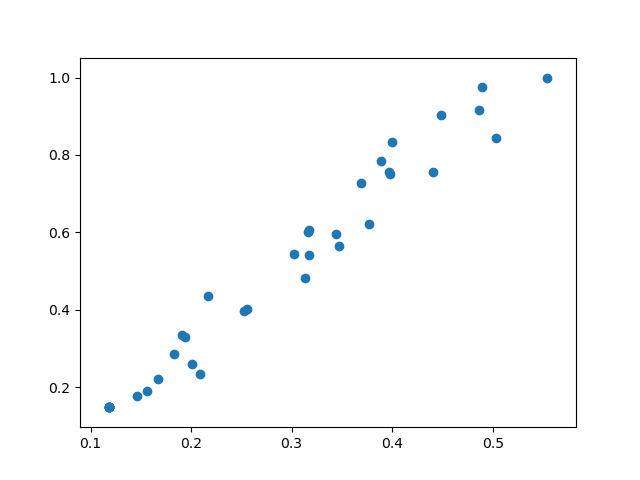

In [132]:
plt.figure()
plt.scatter(XXhat[:36,0],XXhat[36:72,0])

<IPython.core.display.Javascript object>


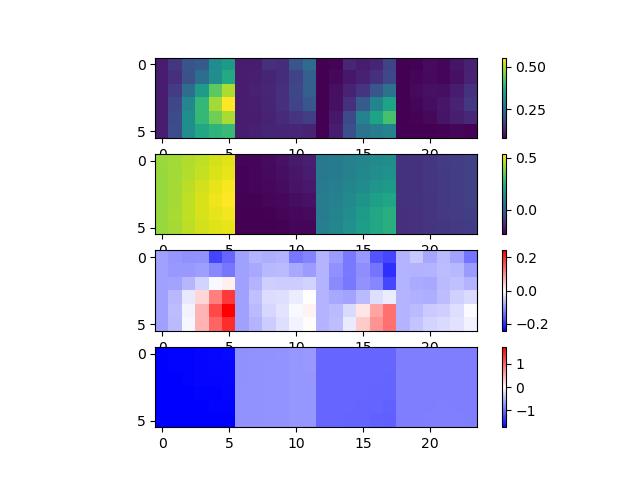

<IPython.core.display.Javascript object>


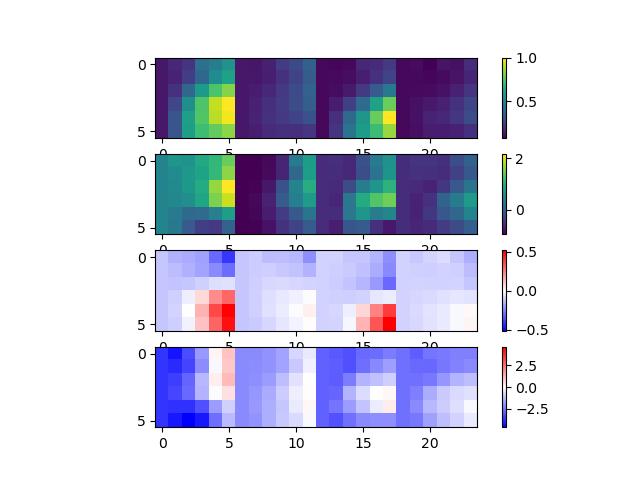

In [148]:
nrun = 1
xrgs = [range(k*nP,k*nP+1) for k in range(4)]
for slc,shp in zip([slice(0,36),slice(36,72)],[(6,6),(6,6)]):
    plt.figure()
    for iitype,itype in enumerate(zip(*xrgs)):
#         plt.subplot(1,4,iitype+1)
        plt.subplot(4,1,iitype+1)
        plt.imshow(XXhat[slc,list(itype)].reshape((nrun,)+shp+(len(xrgs),)).transpose((0,1,3,2)).reshape((nrun*shp[0],len(xrgs)*shp[1])))
        plt.colorbar()
#     plt.figure()
    for iitype,itype in enumerate(zip(*xrgs)):
#         plt.subplot(1,4,iitype+1)
        plt.subplot(4,1,1+iitype+1)
        plt.imshow(np.nanmean(XXs[lkat],0)[slc,list(itype)].reshape((nrun,)+shp+(len(xrgs),)).transpose((0,1,3,2)).reshape((nrun*shp[0],len(xrgs)*shp[1])))
        plt.colorbar()
#     plt.figure()
    for iitype,itype in enumerate(zip(*xrgs)):
#         plt.subplot(1,4,iitype+1)
        plt.subplot(4,1,2+iitype+1)        
        ut.imshow_hot_cold(XXphat[slc,list(itype)].reshape((nrun,)+shp+(len(xrgs),)).transpose((0,1,3,2)).reshape((nrun*shp[0],len(xrgs)*shp[1])))
        plt.colorbar()
#     plt.figure()
    for iitype,itype in enumerate(zip(*xrgs)):
#         plt.subplot(1,4,iitype+1)
        plt.subplot(4,1,3+iitype+1)
        ut.imshow_hot_cold(np.nanmean(XXps[lkat],0)[slc,list(itype)].reshape((nrun,)+shp+(len(xrgs),)).transpose((0,1,3,2)).reshape((nrun*shp[0],len(xrgs)*shp[1])))
        plt.colorbar()

<IPython.core.display.Javascript object>


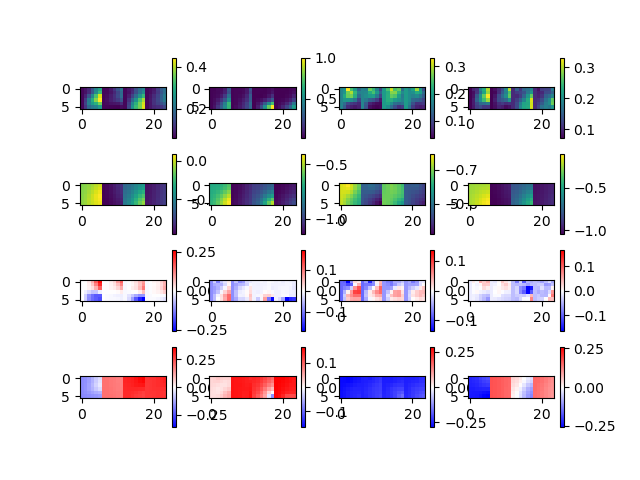

<IPython.core.display.Javascript object>


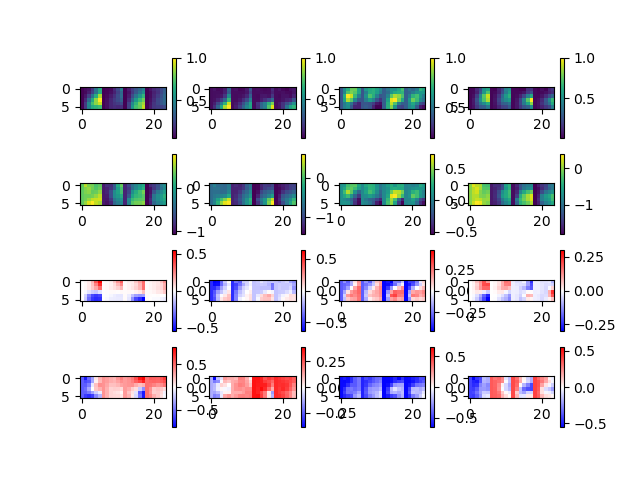

<IPython.core.display.Javascript object>


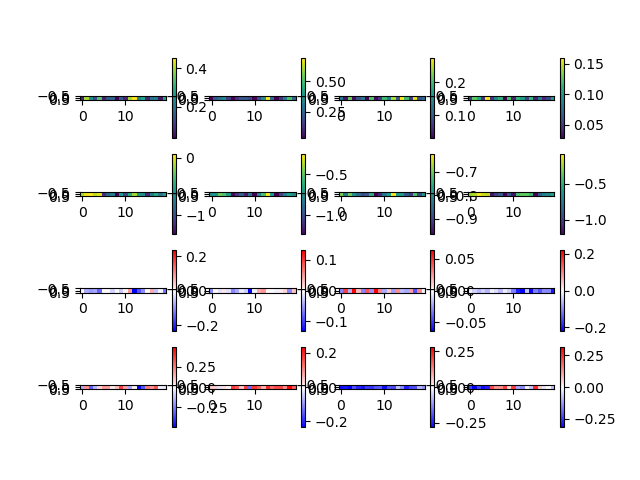

<IPython.core.display.Javascript object>


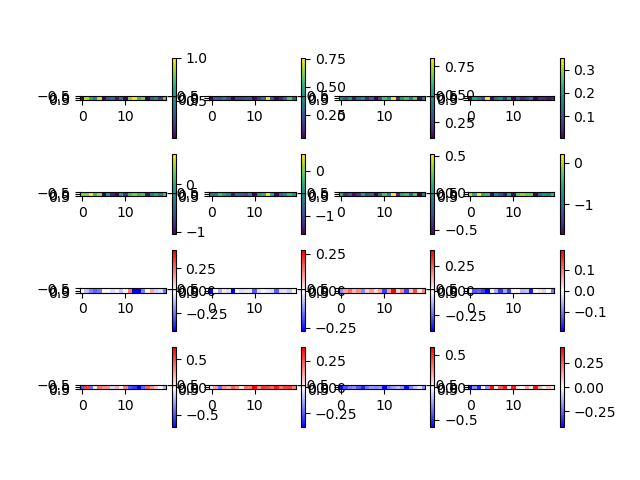

In [153]:
nrun = 1
rgs = [range(0,4),range(4,8),range(8,12),range(12,16)]
for slc,shp in zip([slice(0,36),slice(36,72),slice(72,77),slice(77,82)],[(6,6),(6,6),(1,5),(1,5)]):
    plt.figure()
    for iitype,itype in enumerate(zip(*rgs)):
#         plt.subplot(1,4,iitype+1)
        plt.subplot(4,4,iitype+1)
        plt.imshow(YYhat[slc,list(itype)].reshape((nrun,)+shp+(len(rgs),)).transpose((0,1,3,2)).reshape((nrun*shp[0],len(rgs)*shp[1])))
        plt.colorbar()
#     plt.figure()
    for iitype,itype in enumerate(zip(*rgs)):
#         plt.subplot(1,4,iitype+1)
        plt.subplot(4,4,4+iitype+1)
        plt.imshow(np.nanmean(Etas[lkat],0)[slc,list(itype)].reshape((nrun,)+shp+(len(rgs),)).transpose((0,1,3,2)).reshape((nrun*shp[0],len(rgs)*shp[1])))
        plt.colorbar()
#     plt.figure()
    for iitype,itype in enumerate(zip(*rgs)):
#         plt.subplot(1,4,iitype+1)
        plt.subplot(4,4,8+iitype+1)        
        ut.imshow_hot_cold(YYphat[slc,list(itype)].reshape((nrun,)+shp+(len(rgs),)).transpose((0,1,3,2)).reshape((nrun*shp[0],len(rgs)*shp[1])))
        plt.colorbar()
#     plt.figure()
    for iitype,itype in enumerate(zip(*rgs)):
#         plt.subplot(1,4,iitype+1)
        plt.subplot(4,4,12+iitype+1)
        ut.imshow_hot_cold(np.nanmean(Xis[lkat],0)[slc,list(itype)].reshape((nrun,)+shp+(len(rgs),)).transpose((0,1,3,2)).reshape((nrun*shp[0],len(rgs)*shp[1])))
        plt.colorbar()

In [633]:
YY,YYp = fmc.compute_f_fprime_t_avg_(W1,W2,0,burn_in=0.5,max_dist=1,opt=opt)
YY2 = fmc.compute_f_(Eta,Xi,s02,opt=opt)
YYp2 = fmc.compute_fprime_(Eta,Xi,s02,opt=opt)

<IPython.core.display.Javascript object>


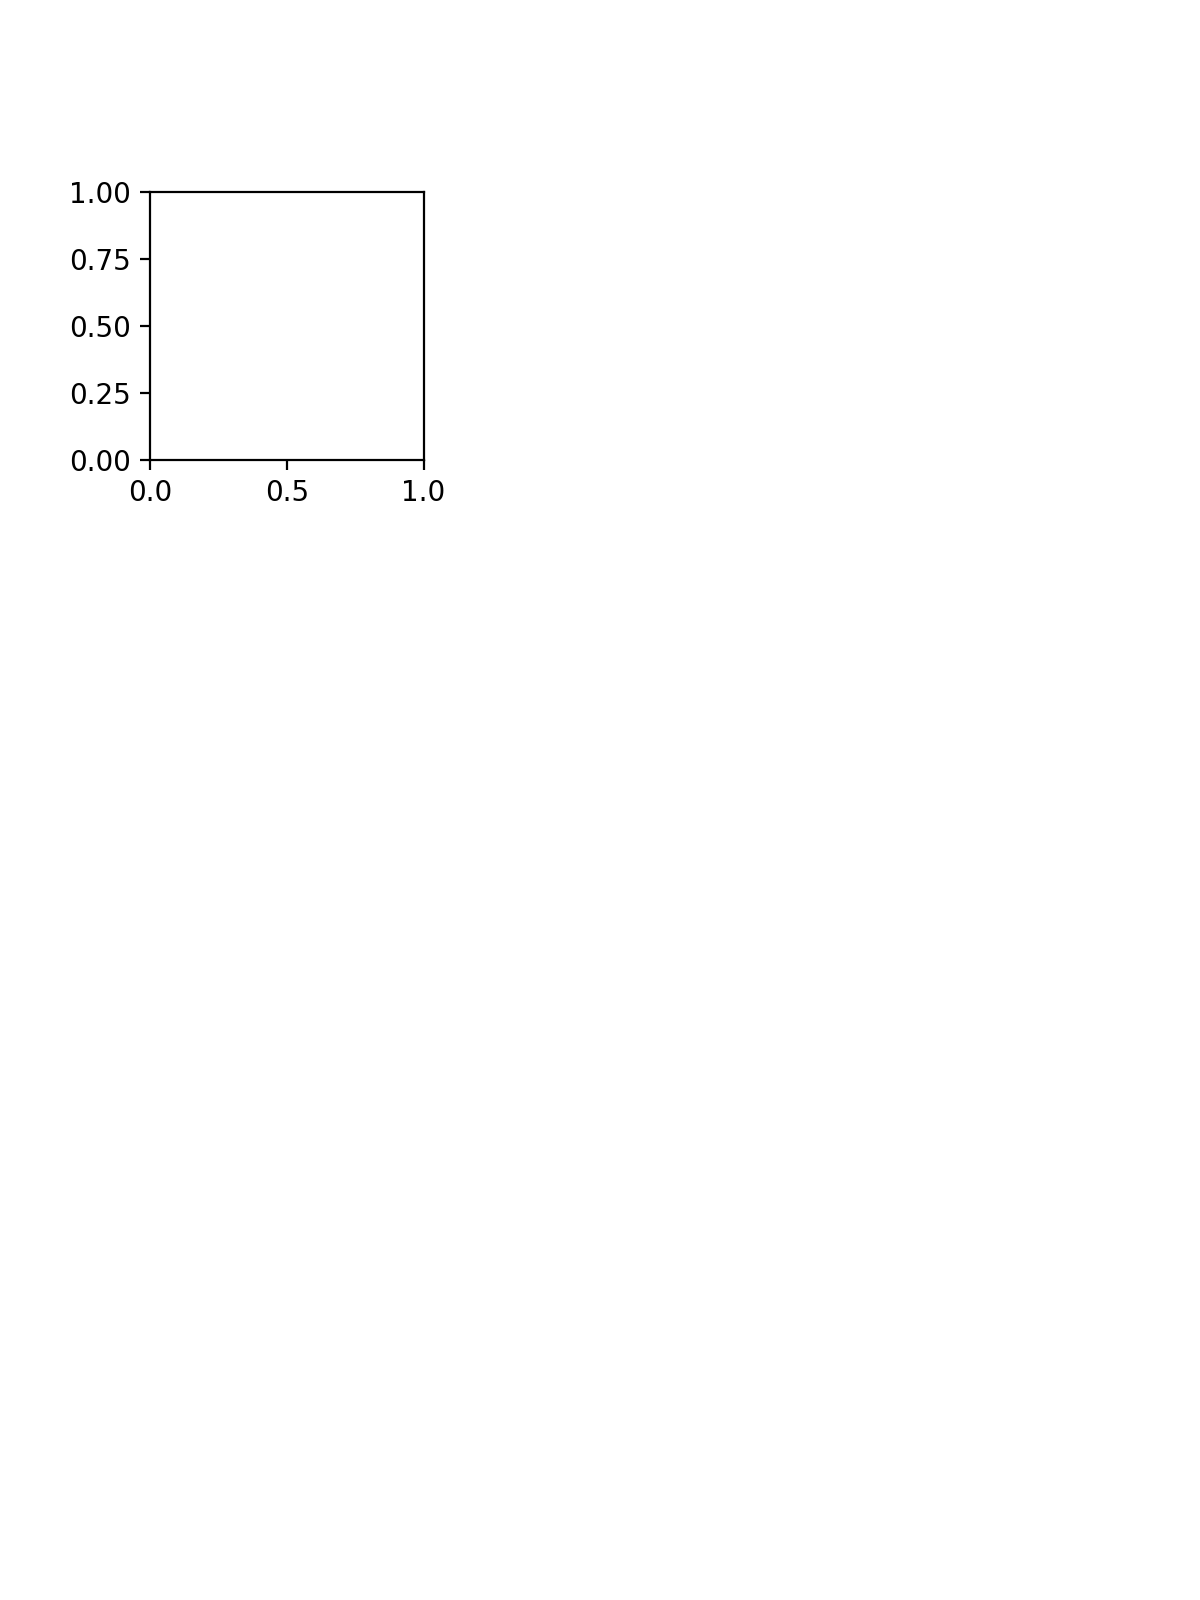

NameError: name 'ralpha' is not defined

In [50]:
nalpha = 3
for itype in range(nQ):
    plt.figure(figsize=(6,8))
    for ipix in range(nS*nT):
        for ialpha in range(nalpha):
            plt.subplot(4,nalpha,ipix*nalpha+ialpha+1)
            sca.show_size_contrast(np.nanmean(ralpha[lkat,:36,ipix*nQ+itype,ialpha],0).reshape((6,6)),flipud=True,vmin=0,vmax=1)
            plt.colorbar()
    plt.tight_layout()

<IPython.core.display.Javascript object>


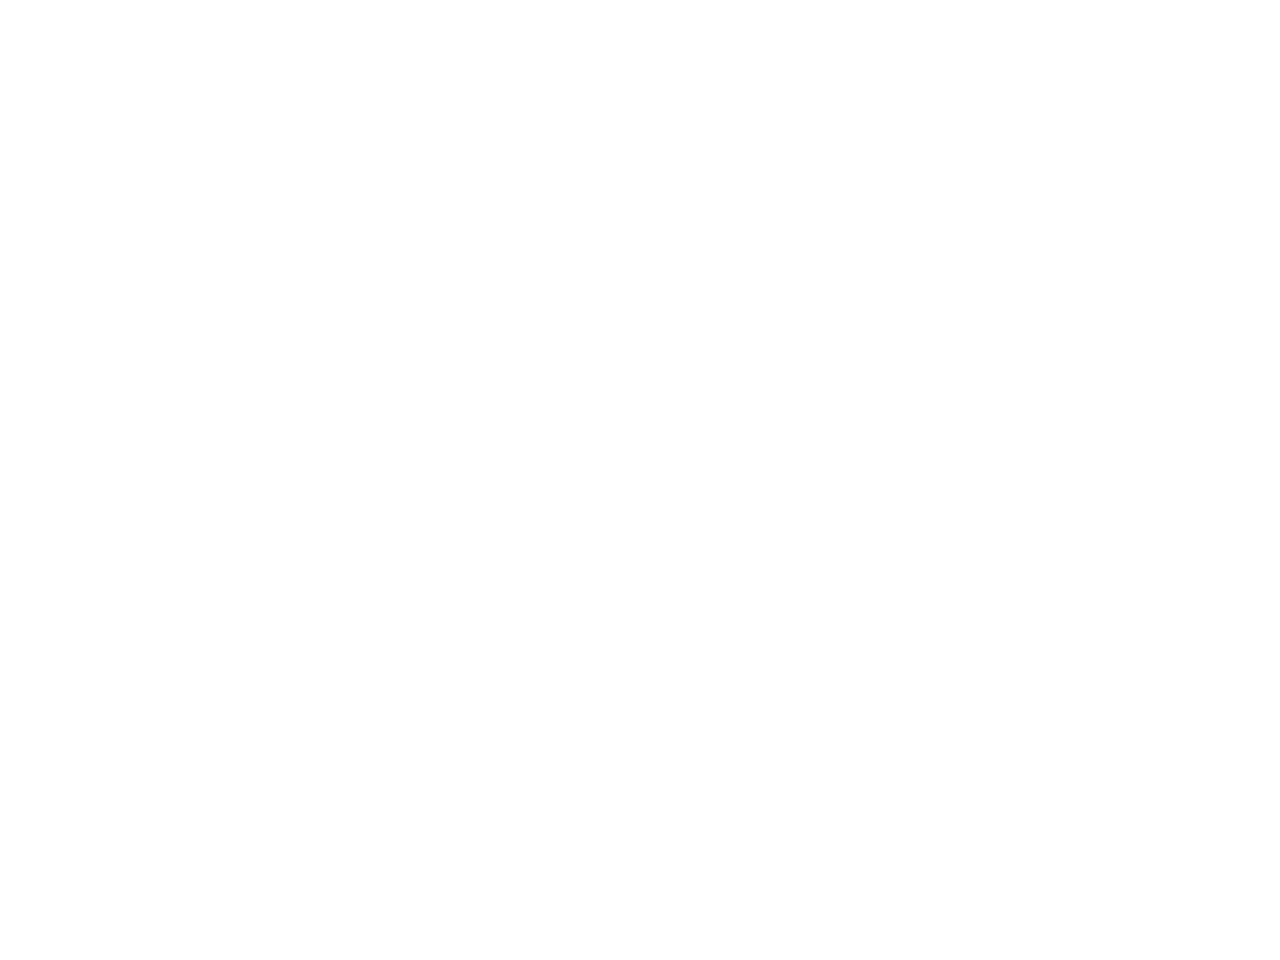

IndexError: index 5 is out of bounds for axis 0 with size 5

In [491]:
itype = 0
plt.figure()
for iwt in range(18):
    plt.subplot(6,3,iwt+1)
    plt.imshow(np.flipud(ralpha[lkat][iwt,:36,itype,:].reshape((6,6,3)).transpose((0,2,1)).reshape((6,18))))

<IPython.core.display.Javascript object>


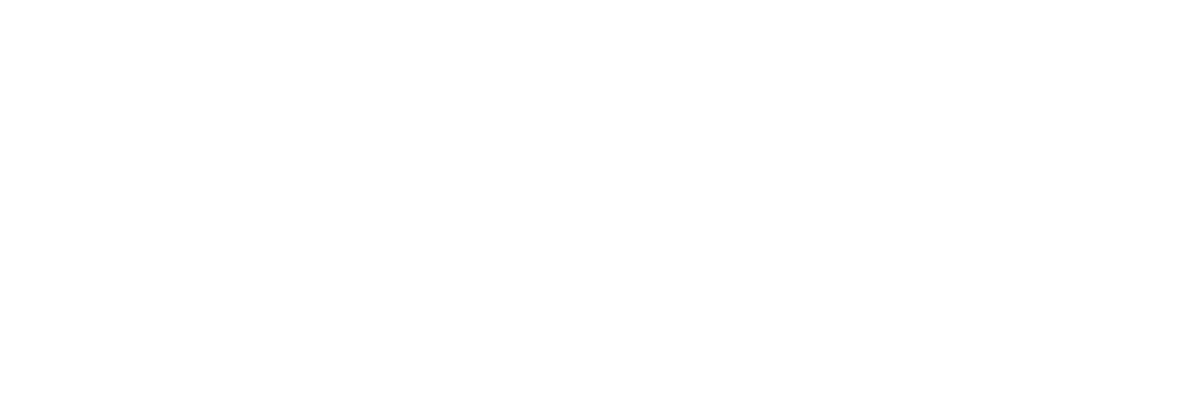

NameError: name 'Ypc_list' is not defined

In [492]:
ipc = 0
lbls = ['pc','sst','vip','pv']
for iQ in range(nQ):
    plt.figure(figsize=(6,2))
    for iS in range(1):
        for iT in range(1):
            ipix = np.ravel_multi_index((iS,iT),(nS,nT))
            ysigma = Ypc_list[iS][iT][iQ][ipc][0]*Ypc_list[iS][iT][iQ][ipc][1]
            for ialpha,alpha in enumerate((-1,0,1)):
                plt.subplot(1,3,ipix*3+ialpha+1)
                sca.show_size_contrast((YYhat[:,ipix*nQ+iQ]+alpha*ysigma).reshape((6,6)),flipud=True)
                plt.colorbar()
    plt.tight_layout()
#     plt.savefig('figures/%s_mean_plus_pcs.eps'%lbls[iQ])

<IPython.core.display.Javascript object>


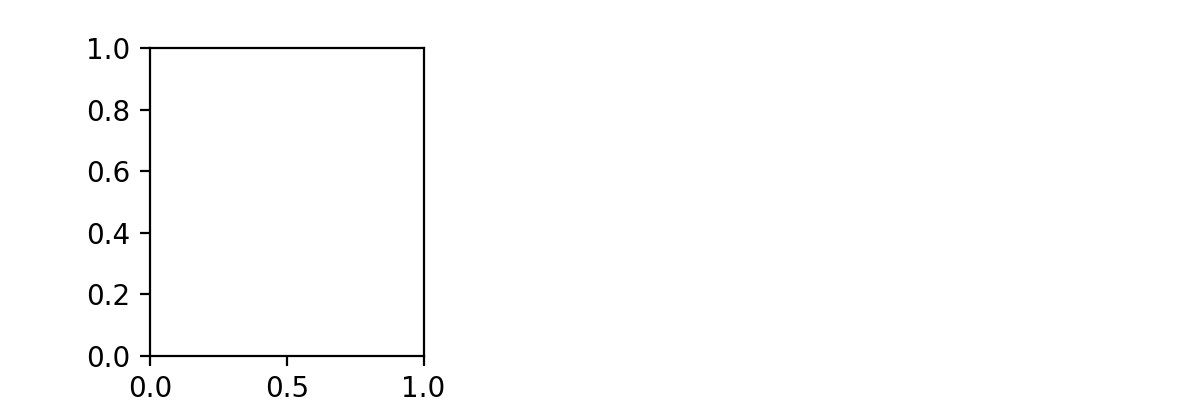

ValueError: cannot reshape array of size 41 into shape (6,6)

In [493]:
for itype in range(nQ):
    plt.figure(figsize=(6,2))
    for ipix in range(1):
        for ialpha in range(nalpha):
            plt.subplot(1,nalpha,ialpha+1)
            if itype!=2:
                sca.show_size_contrast(np.nanmean(ralpha[lkat,:,ipix*nQ+itype,ialpha],0).reshape((6,6)),flipud=True)
            else:
                sca.show_size_contrast(np.nanmean(ralpha[lkat,:,ipix*nQ+itype,2-ialpha],0).reshape((6,6)),flipud=True)
            plt.colorbar()
    plt.tight_layout()
#     plt.savefig('figures/%s_sim_mean_plus_pcs.eps'%lbls[itype])

<IPython.core.display.Javascript object>


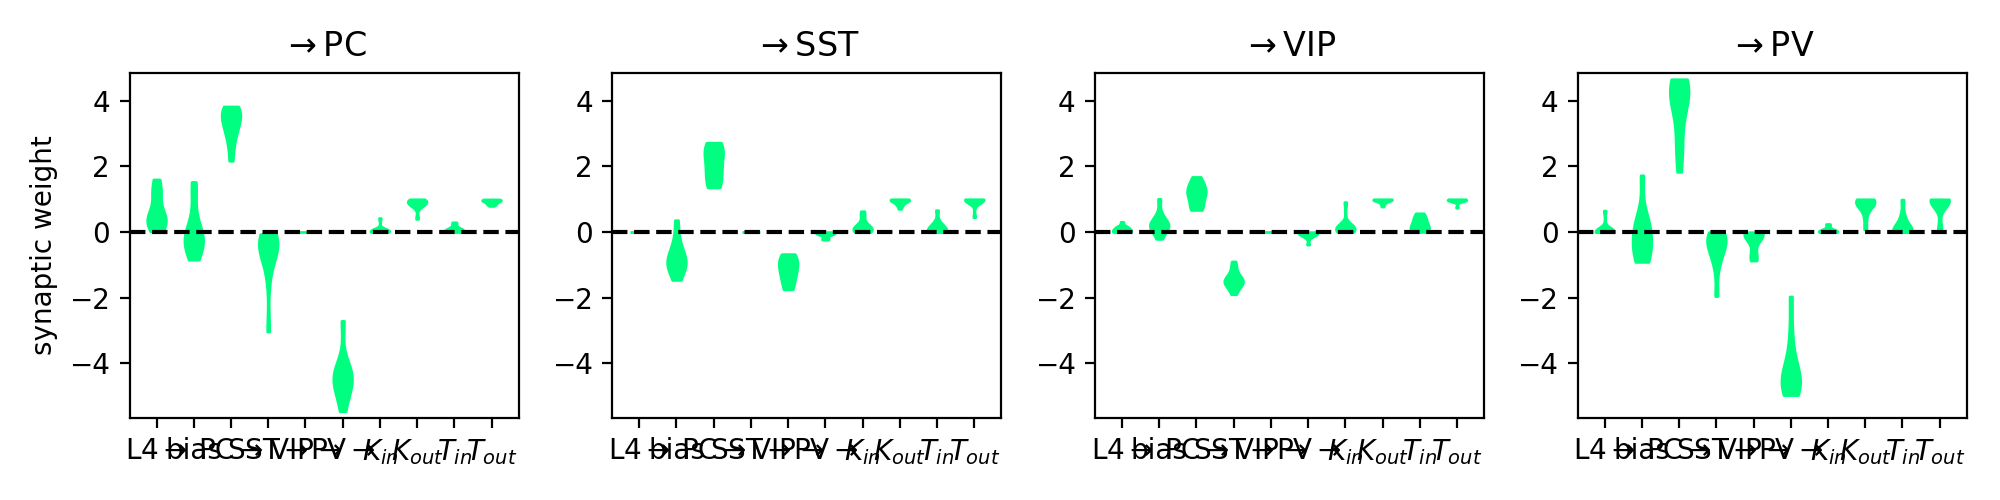

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<IPython.core.display.Javascript object>


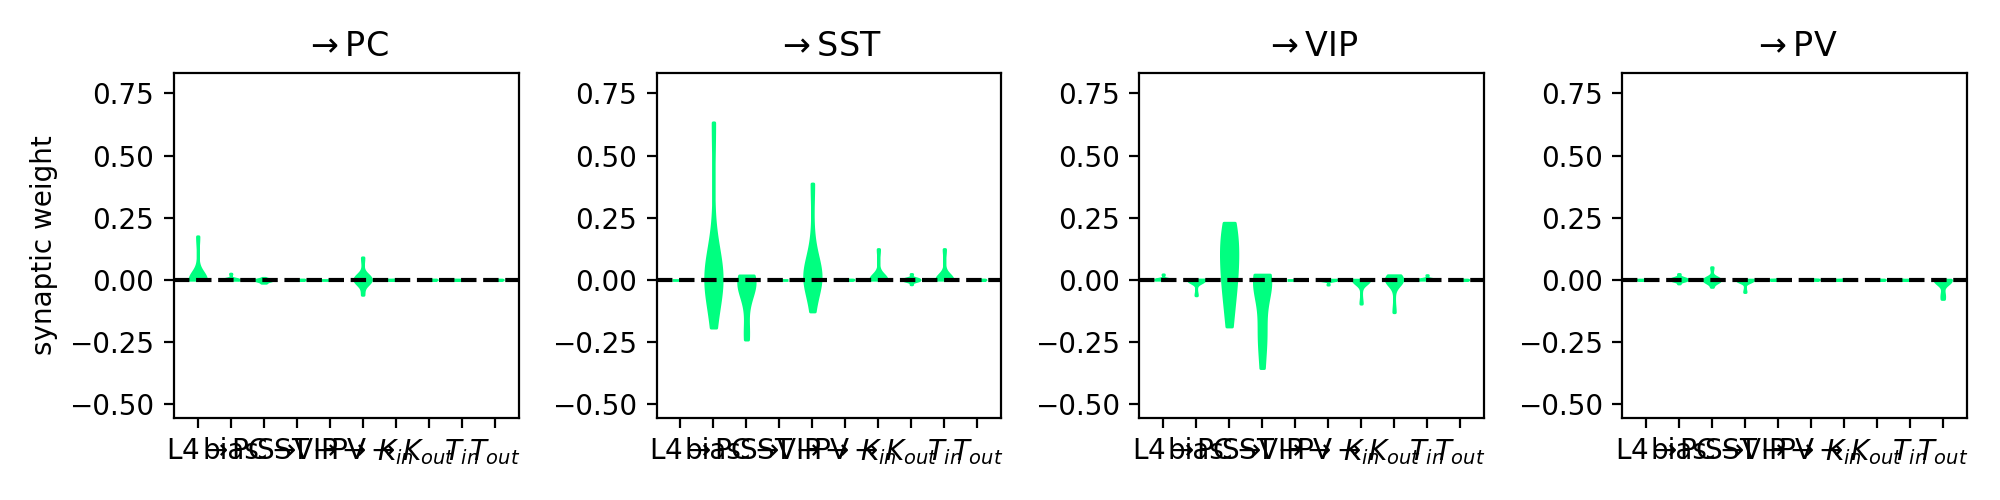

<IPython.core.display.Javascript object>


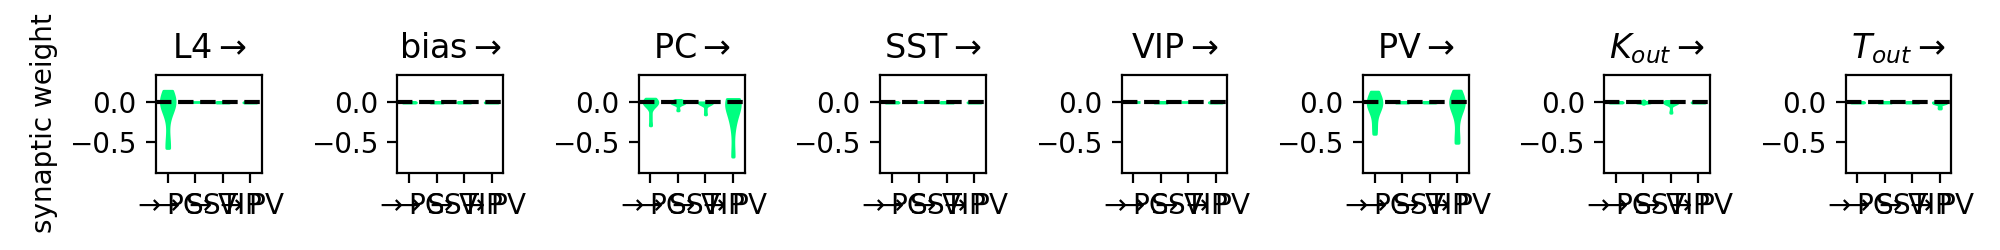

<IPython.core.display.Javascript object>


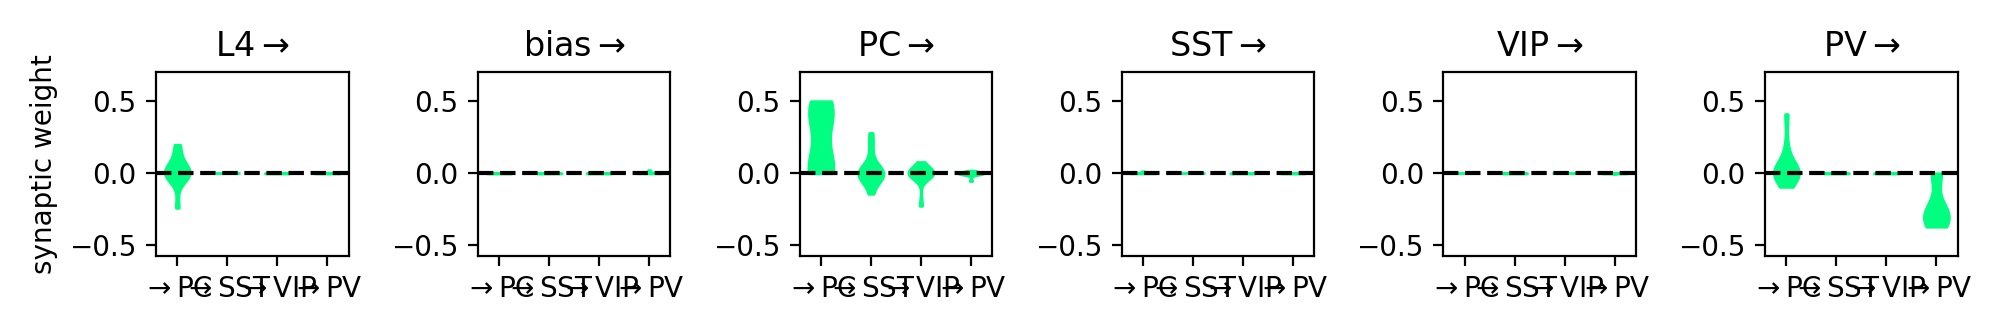

In [635]:
def violin_plot_weights(W,titles=['PC','SST','VIP','PV'],xlbls=None,color=[0,1,0.5],show_cols=True):
    if xlbls is None:
        if show_cols:
            xlbls = ['%s'%t + r'$\rightarrow$' for t in titles]
        else:
            xlbls = [r'$\rightarrow$' + '%s'%t for t in titles]
    if show_cols:
        nQ = W.shape[-1]
    else:
        nQ = W.shape[-2]
    plt.figure(figsize=(10,10/nQ))
    for data in [W]:#,[Wsx,Wsy]]:
#         titles = ['PC','SST','VIP','PV']
#         data = datas[0]
        if show_cols:
            x = np.arange(1,data.shape[1]+1)
        else:
            x = np.arange(1,data.shape[2]+1)
#         xlbl = ['PC->','SST->','VIP->','PV->']
        for icelltype in range(nQ):
            plt.subplot(1,nQ,icelltype+1)
    #         plt.violinplot([data[:,i,icelltype] for i in range(data.shape[1])])
            if show_cols:
                violin_parts = plt.violinplot([data[:,i,icelltype] for i in range(data.shape[1])],showextrema=False)
            else:
                violin_parts = plt.violinplot([data[:,icelltype,i] for i in range(data.shape[2])],showextrema=False)
            for pc in violin_parts['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_alpha(1)
            plt.axhline(0,c='k',linestyle='dashed')
            plt.xticks(x,xlbls)
            plt.ylim(data.min()-0.2,data.max()+0.2)
            plt.title(titles[icelltype])
        plt.subplot(1,nQ,1)
        plt.ylabel('synaptic weight')
        plt.tight_layout()
show_cols = [True,True,False,False]
for iwt in range(2):
    this_W = np.concatenate((Wxs[iwt][lkat],Wys[iwt][lkat],Ks[iwt][lkat,np.newaxis],Kys[iwt][lkat,np.newaxis],Ts[iwt][lkat,np.newaxis],Tys[iwt][lkat,np.newaxis]),axis=1)
    titles = [r'$\rightarrow$'+x for x in ['PC','SST','VIP','PV']]
    xlbls = ['L4'+r'$\rightarrow$','bias','PC'+r'$\rightarrow$','SST'+r'$\rightarrow$','VIP'+r'$\rightarrow$','PV'+r'$\rightarrow$',r'$K_{in}$',r'$K_{out}$',r'$T_{in}$',r'$T_{out}$']
    violin_plot_weights(this_W,show_cols=show_cols[iwt],titles=titles,xlbls=xlbls)
for iwt in range(2,3):
    this_W = np.concatenate((Wxs[iwt][lkat],Wys[iwt][lkat],Kys[iwt-1][lkat,np.newaxis],Tys[iwt-1][lkat,np.newaxis]),axis=1)
    titles = [x+r'$\rightarrow$' for x in ['L4','bias','PC','SST','VIP','PV',r'$K_{out}$',r'$T_{out}$']]
    xlbls = [r'$\rightarrow$'+'PC',r'$\rightarrow$'+'SST',r'$\rightarrow$'+'VIP',r'$\rightarrow$'+'PV']
    violin_plot_weights(this_W,show_cols=show_cols[iwt],titles=titles,xlbls=xlbls)
for iwt in range(3,4):
    this_W = np.concatenate((Wxs[iwt][lkat],Wys[iwt][lkat]),axis=1)
    titles = [x+r'$\rightarrow$' for x in ['L4','bias','PC','SST','VIP','PV']]
    xlbls = [r'$\rightarrow$'+'PC',r'$\rightarrow$'+'SST',r'$\rightarrow$'+'VIP',r'$\rightarrow$'+'PV']
    violin_plot_weights(this_W,show_cols=show_cols[iwt],titles=titles,xlbls=xlbls)
# plt.savefig('figures/violinplots_fit_weights.jpg',dpi=300)

In [539]:
def gen_WWs(Ws,Ks,Ts):
    iwt0 = 0
    power0 = True
    power1 = False
    iwt = 0
    WWs = [None for thisWs in Ws]
    nfit = Ws[0].shape[0]
    WWs[iwt] = np.array([calnet.utils.gen_Weight_k_kappa_t(Ws[iwt][ifit],Ks[iwt][ifit],1,Ts[iwt][ifit],power=power0) for ifit in range(nfit)])
    for iwt in range(1,4):
        WWs[iwt] = np.array([calnet.utils.gen_Weight_k_kappa_t(Ws[iwt][ifit],Ks[iwt0][ifit],1,Ts[iwt0][ifit],power=power0) \
                    + calnet.utils.gen_Weight_k_kappa_t(Ws[iwt0][ifit],Ks[iwt][ifit],1,Ts[iwt0][ifit],power=power1) \
                    + calnet.utils.gen_Weight_k_kappa_t(Ws[iwt0][ifit],Ks[iwt0][ifit],1,Ts[iwt][ifit],power=power1) \
                    for ifit in range(nfit)])
    return WWs

In [540]:
lkat.sum()

20

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


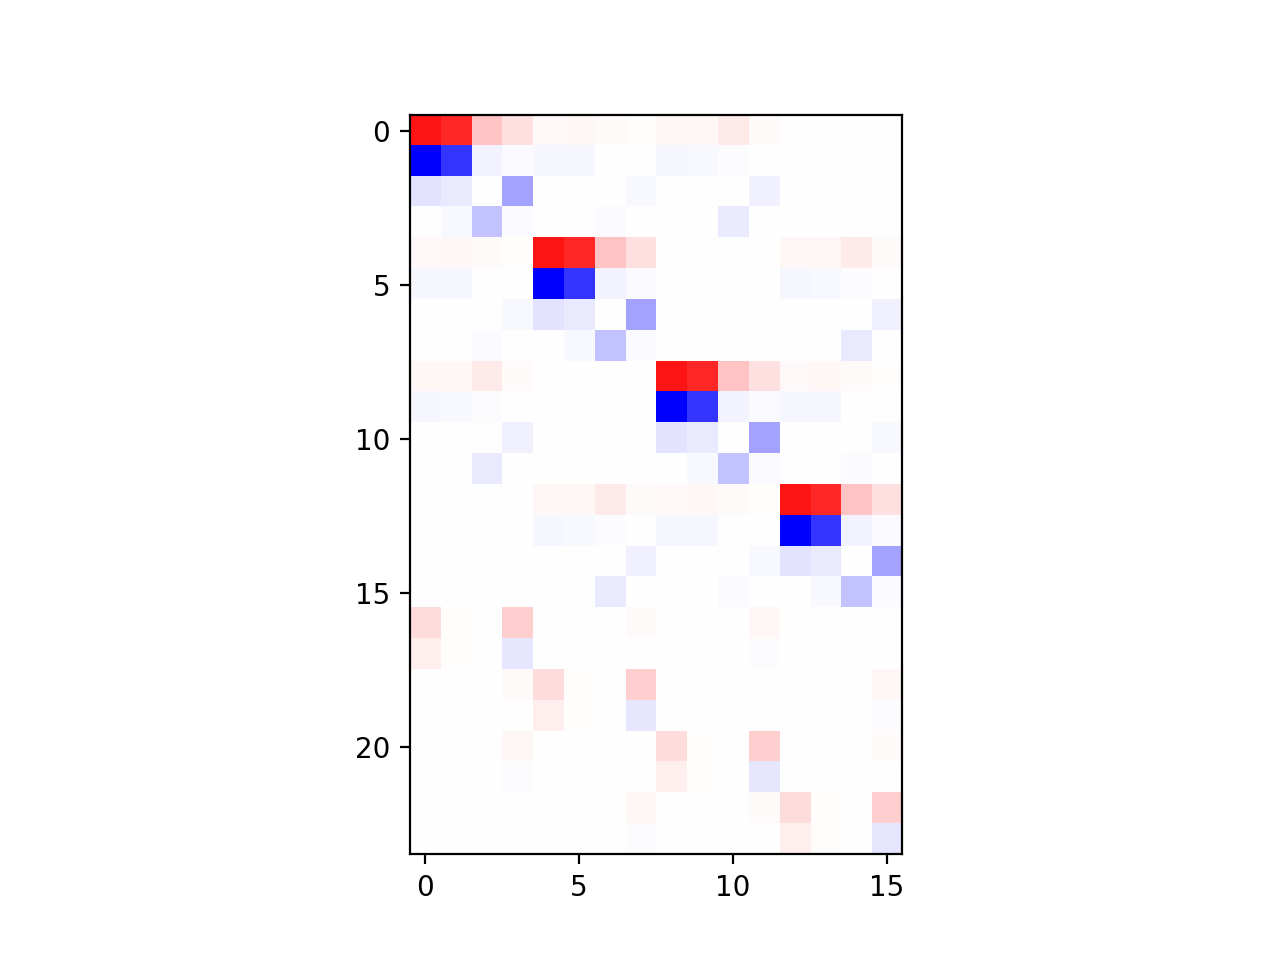

In [541]:
disp_order = [0,3,1,2]
ddisp_order = list(np.concatenate([np.array([0,3,1,2])+4*q for q in range(4)]).astype('int'))
lbls = ['PC','PV','SST','VIP']
inp_lbls = ['L2/3 PC','L2/3 PV','L2/3 SST','L2/3 VIP','L4 PC','bias']
WWys = gen_WWs(Wys,Ks,Ts)
WWxs = gen_WWs(Wxs,Ks,Ts)
# WWys = [calnet.utils.gen_Weight_k_kappa_t(Wys[iwt][ifit],Ks[iwt][ifit],1,Ts[iwt][ifit]) for iwt in range(4)]
Wdata = [np.nanmean(np.concatenate((Wys[iwt][lkat][:,disp_order][:,:,disp_order],Wxs[iwt][lkat][:,:,disp_order]),axis=1),0) for iwt in range(4)]
WWdata = [np.nanmean(np.concatenate((WWys[iwt][lkat][:,ddisp_order][:,:,ddisp_order],WWxs[iwt][lkat][:,:,ddisp_order]),axis=1),0) for iwt in range(4)]
plt.figure()
ut.imshow_hot_cold(WWdata[0])
# plt.xticks(np.arange(4),[r'$\rightarrow$'+lbl for lbl in lbls])
# plt.yticks(np.arange(6),[lbl+r'$\rightarrow$' for lbl in inp_lbls])
# plt.ylim((5.5,-0.5))
# plt.tight_layout()

In [562]:
nfiles = len(weights_files)
T0s = np.zeros((nfiles,nQ))
T1s = np.zeros((nfiles,nQ))
T2s = np.zeros((nfiles,nQ))
T3s = np.zeros((nfiles,nQ))
K0s = np.zeros((nfiles,nQ))
K1s = np.zeros((nfiles,nQ))
K2s = np.zeros((nfiles,nQ))
K3s = np.zeros((nfiles,nQ))
W0ys = np.zeros((nfiles,nQ,nQ))
W0xs = np.zeros((nfiles,nP,nQ))
W1ys = np.zeros((nfiles,nQ,nQ))
W1xs = np.zeros((nfiles,nP,nQ))
W2ys = np.zeros((nfiles,nQ,nQ))
W2xs = np.zeros((nfiles,nP,nQ))
W3ys = np.zeros((nfiles,nQ,nQ))
W3xs = np.zeros((nfiles,nP,nQ))
s02s = np.zeros((nfiles,nQ))
YYs = np.zeros((nfiles,6,6,nQ*nS*nT))
XXs = np.zeros((nfiles,6,6,nP*nS*nT))
Etas = np.zeros((nfiles,nN,nQ*nS*nT))
Xis = np.zeros((nfiles,nN,nQ*nS*nT))
couplings = np.zeros((nfiles,6,6,nQ*nS*nT,nQ*nS*nT))
# couplings with phiPV = phiPC fixed
couplings_pcpv = np.zeros((nfiles,6,6,nQ*nS*nT,nQ*nS*nT))
Xcouplings = np.zeros((nfiles,6,6,nP*nS*nT,nQ*nS*nT))
phis = np.zeros((nfiles,6,6,nQ*nS*nT))
losses = np.zeros((nfiles,))
for iwt,weights_file in enumerate(weights_files):
    Wstar_dict = np.load(weights_file,allow_pickle=True)[()]
    W0x,W0y,W1x,W1y,W2x,W2y,W3x,W3y,s02,K0,K1,K2,K3,kappa,T0,T1,T2,T3,XX,XXp,Eta,Xi,h = Wstar_dict['as_list']
    losses[iwt] = Wstar_dict['loss']
#     Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi,h1,h2 = Wstar_dict['as_list']
    WWmy = calnet.utils.gen_Weight_k_kappa_t(W0y,K,kappa,T)
    WWmx = calnet.utils.gen_Weight_k_kappa_t(W0x,K,kappa,T)
    tiled_s02 = np.tile(s02,nS*nT)
    T0s[iwt] = T0
    T1s[iwt] = T1
    T2s[iwt] = T2
    T3s[iwt] = T3
    K0s[iwt] = K0
    K1s[iwt] = K1
    K2s[iwt] = K2
    K3s[iwt] = K3
    W0ys[iwt] = W0y
    W0xs[iwt] = W0x
    W1ys[iwt] = W1y
    W1xs[iwt] = W1x
    W2ys[iwt] = W2y
    W2xs[iwt] = W2x
    W3ys[iwt] = W3y
    W3xs[iwt] = W3x
    s02s[iwt] = s02
    Etas[iwt] = Eta
    Xis[iwt] = Xi
    YYs[iwt] = sim_utils.f_miller_troyer(Eta,Xi**2+tiled_s02).reshape((6,6,nQ*nS*nT))
    XXs[iwt] = XX.reshape((6,6,nP*nS*nT))
    for istim in range(nN):
        iistim,jjstim = np.unravel_index(istim,(6,6))
        phis[iwt,iistim,jjstim] = calnet.utils.fprime_miller_troyer(Eta[istim],Xi[istim]**2+tiled_s02)
        phipcpv = phis[iwt,iistim,jjstim].copy()
        phipcpv[3::4] = phipcpv[0::4]
        Phi = np.diag(phis[iwt,iistim,jjstim])
        Phipcpv = np.diag(phipcpv)
        couplings[iwt,iistim,jjstim] = Phi @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phi)
        Xcouplings[iwt,iistim,jjstim] = WWmx @ Phi @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phi)
        couplings_pcpv[iwt,iistim,jjstim] = Phipcpv @ np.linalg.inv(np.eye(nQ*nS*nT) - WWmy @ Phipcpv)
# couplings = np.reshape(couplings,(couplings.shape[0],6,6,couplings.shape[2],couplings.shape[3]))
# Xcouplings = np.reshape(Xcouplings,(Xcouplings.shape[0],6,6,Xcouplings.shape[2],Xcouplings.shape[3]))


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


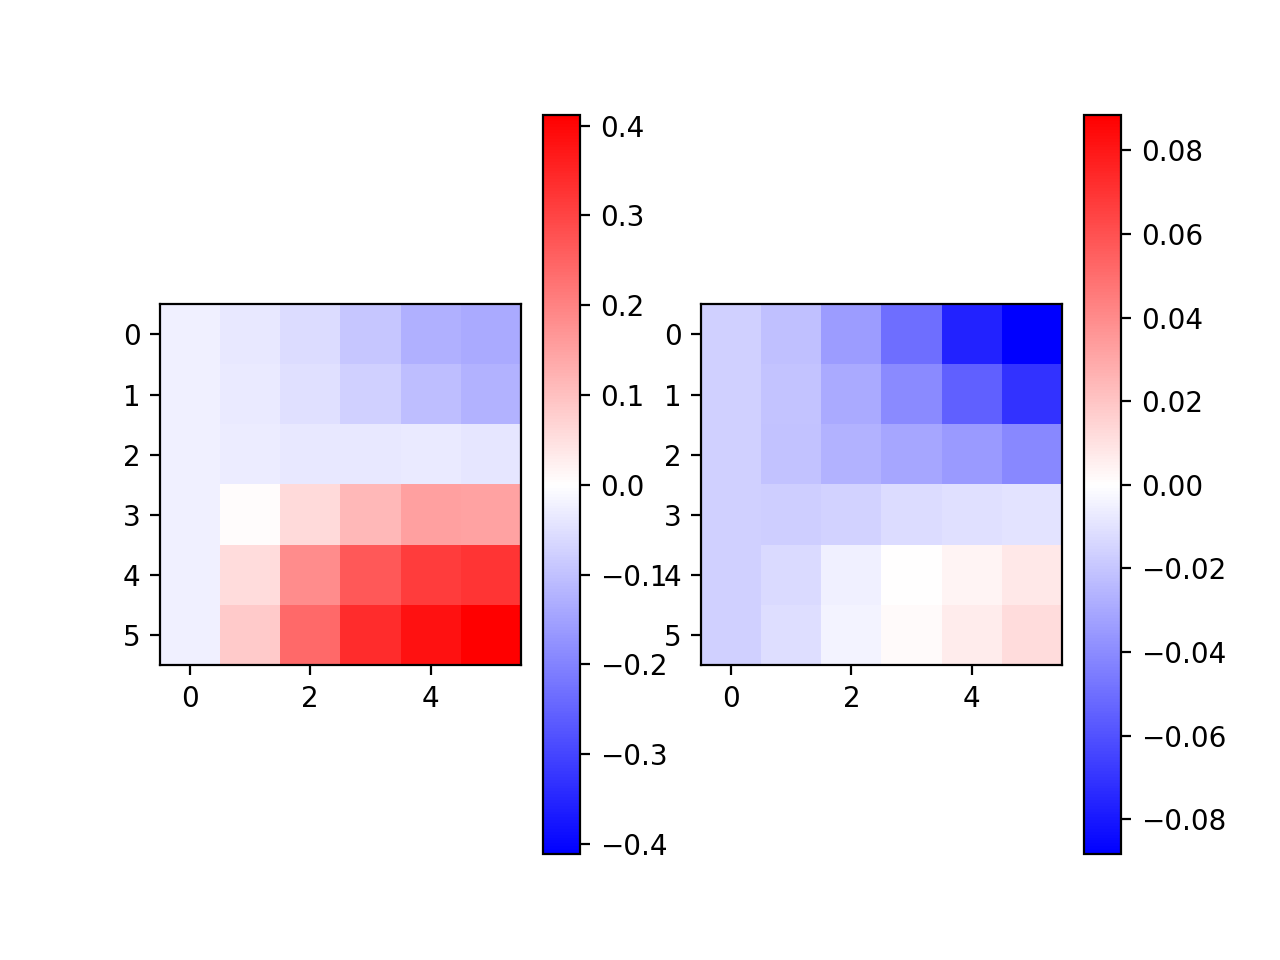

<IPython.core.display.Javascript object>


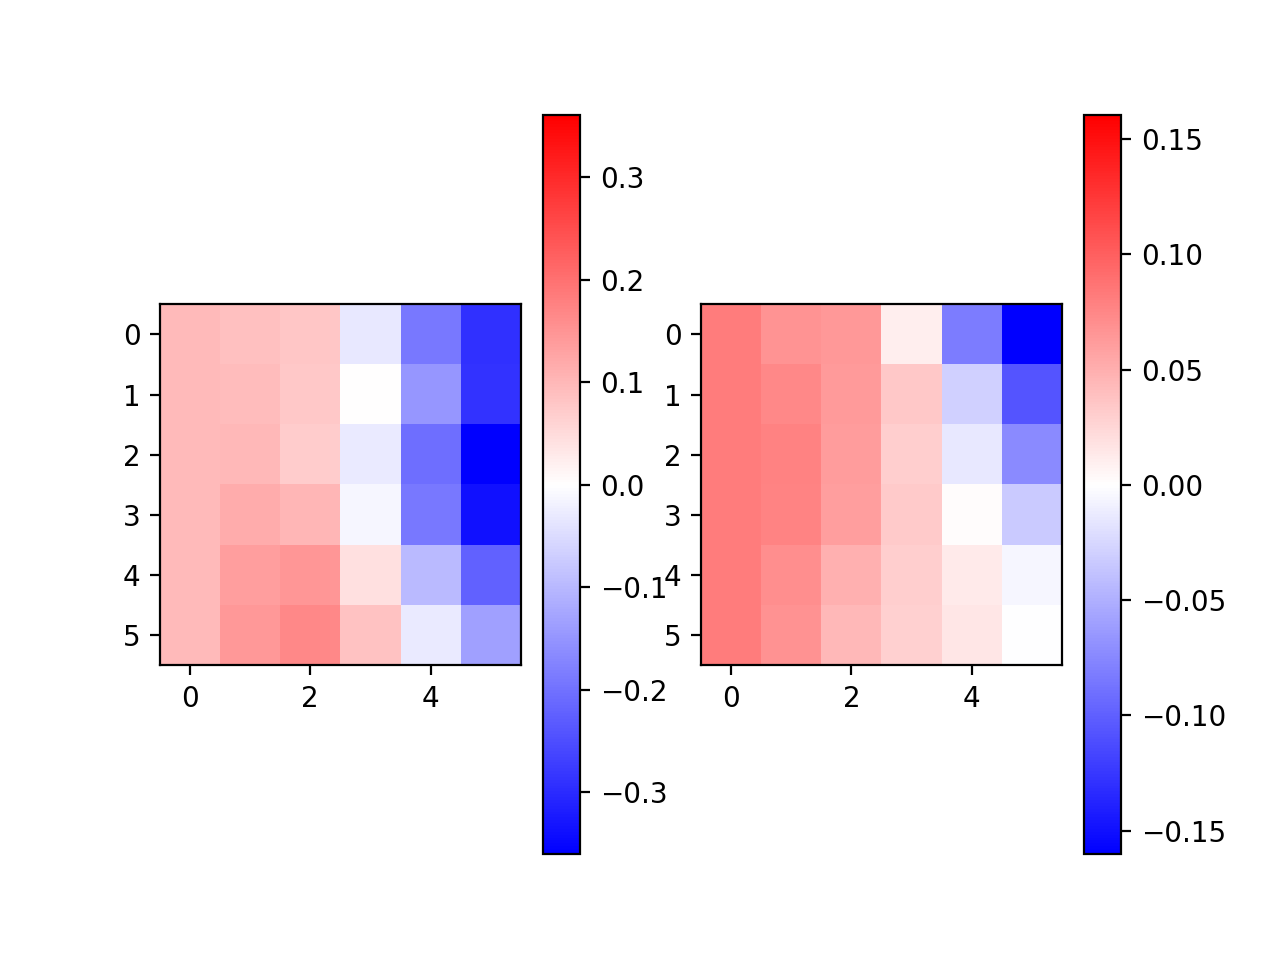

<IPython.core.display.Javascript object>


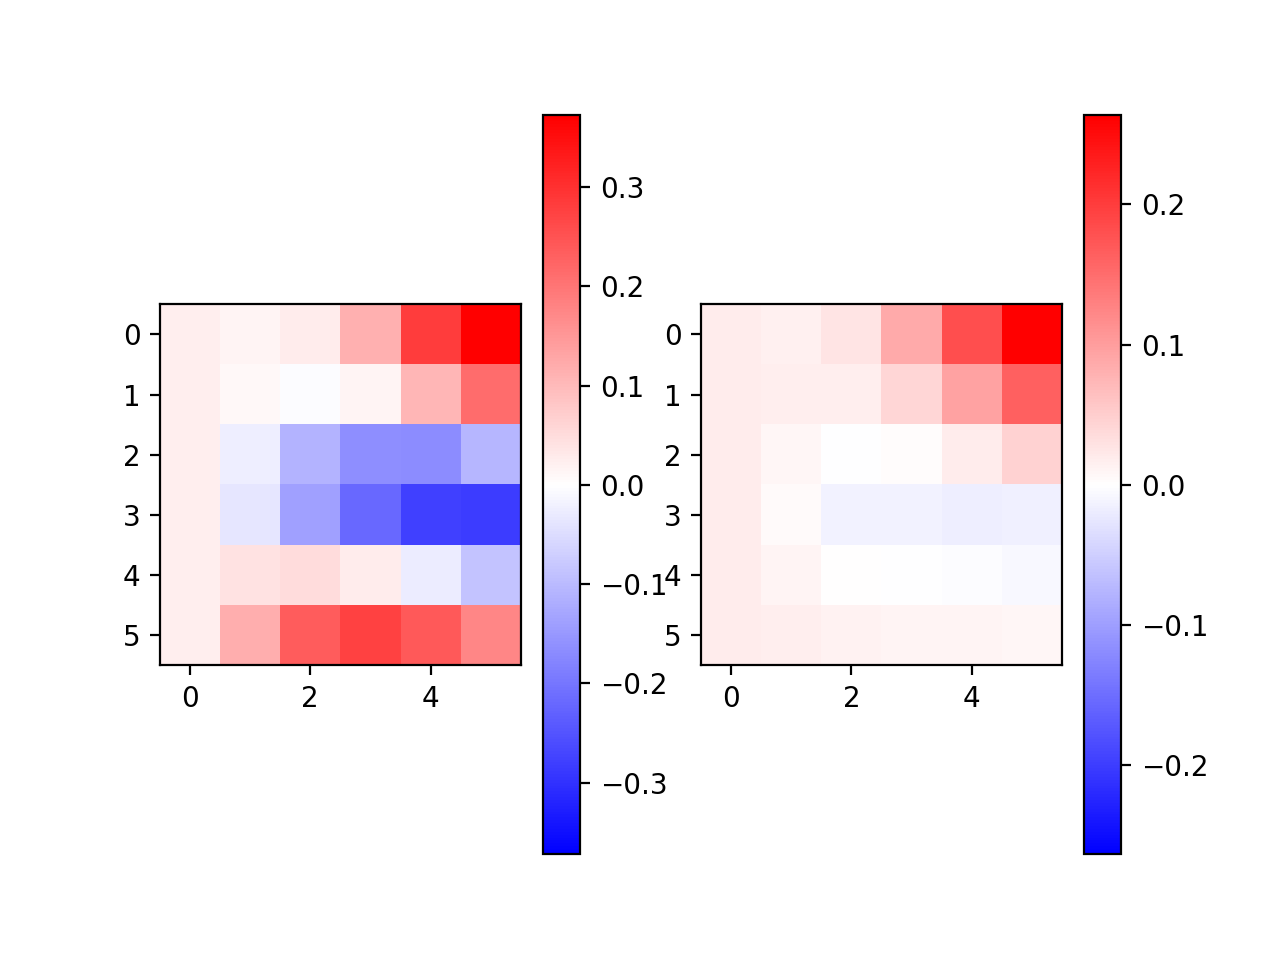

<IPython.core.display.Javascript object>


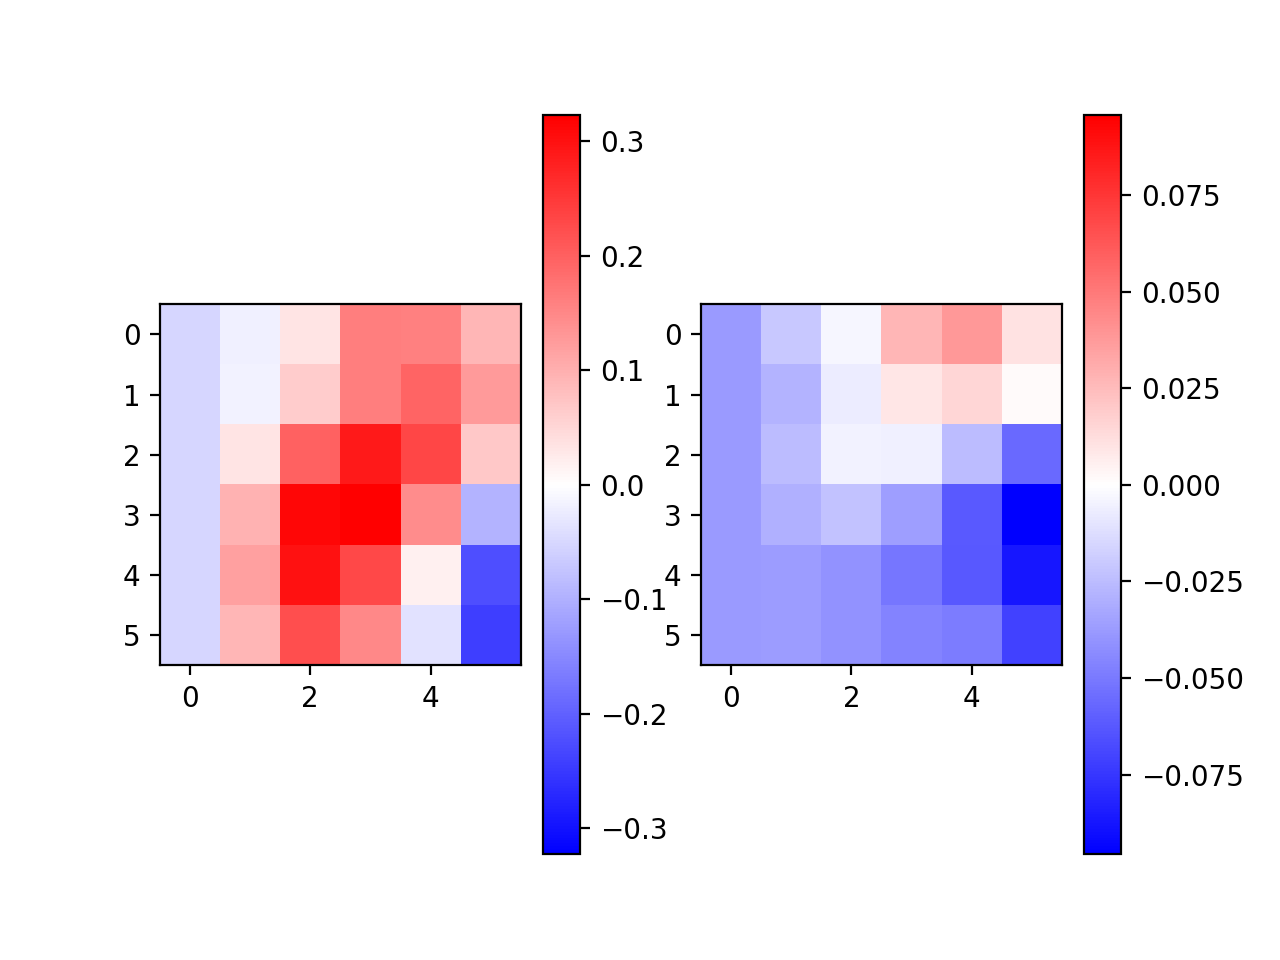

<IPython.core.display.Javascript object>


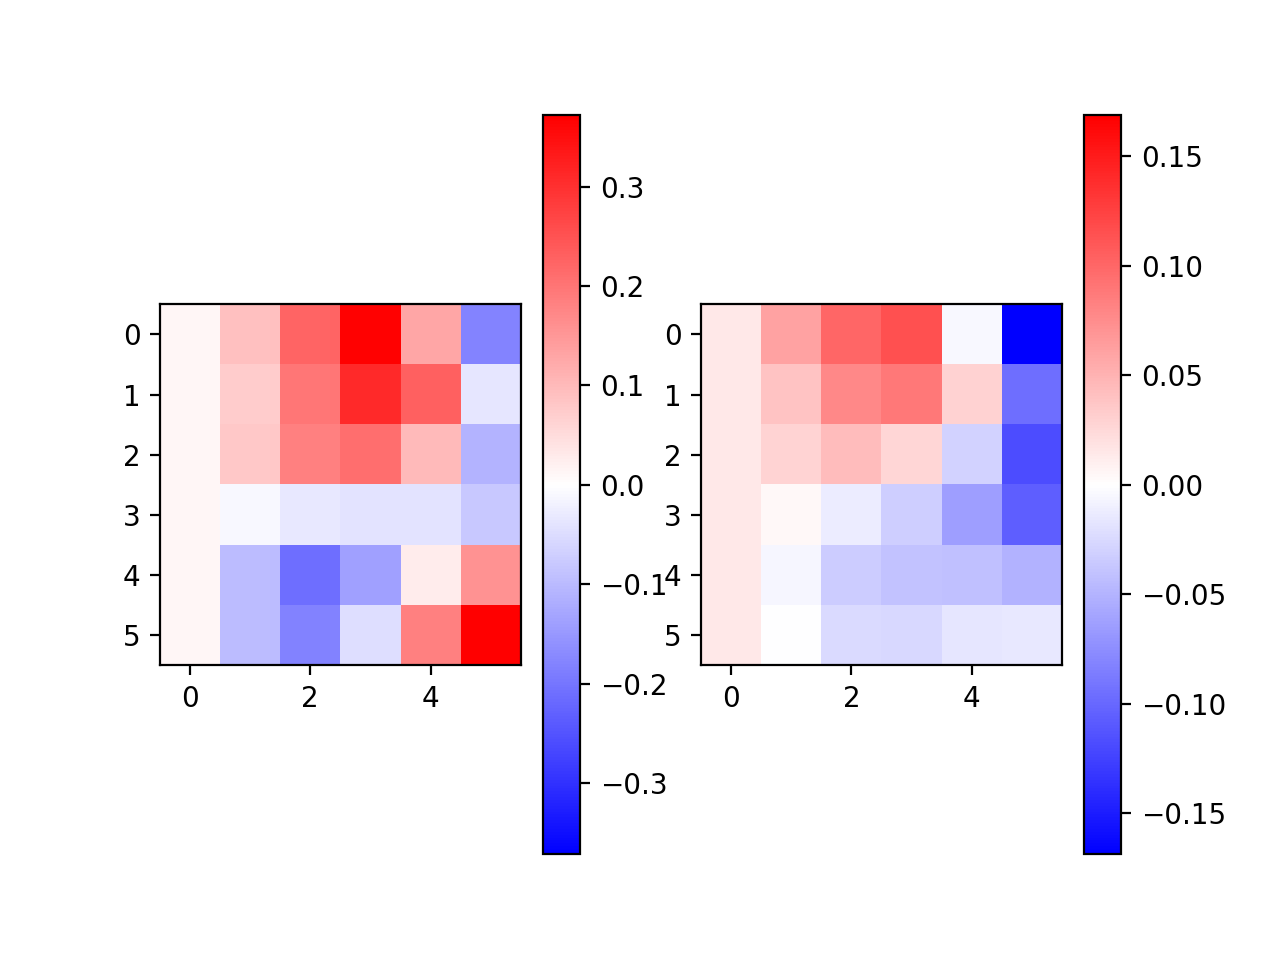

In [616]:
iS,iT = 0,0
iQ = 0
for idim in range(5):
    plt.figure()
    for iT in range(2):
        plt.subplot(1,2,iT+1)
        ut.imshow_hot_cold(Ypc_list[iS][iT][iQ][idim][1].reshape((nsize,ncontrast)))
        plt.colorbar()

<IPython.core.display.Javascript object>


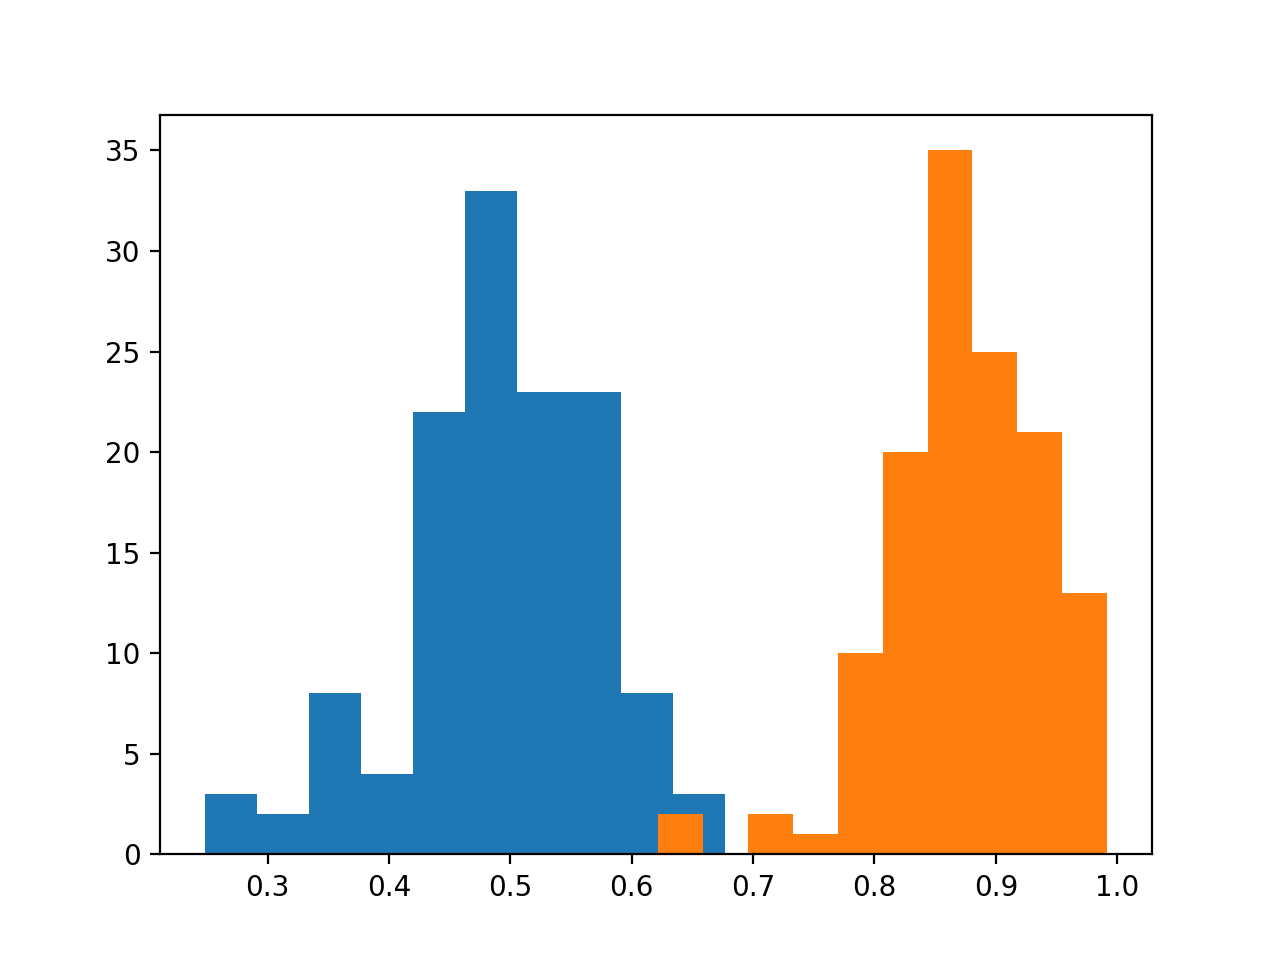

(array([ 2.,  0.,  2.,  1., 10., 20., 35., 25., 21., 13.]),
 array([0.62200249, 0.6589511 , 0.6958997 , 0.73284831, 0.76979692,
        0.80674552, 0.84369413, 0.88064273, 0.91759134, 0.95453994,
        0.99148855]),
 <a list of 10 Patch objects>)

In [507]:
plt.figure()
plt.hist(T0s[lkat,0])
plt.hist(T0s[lkat,1])


<IPython.core.display.Javascript object>


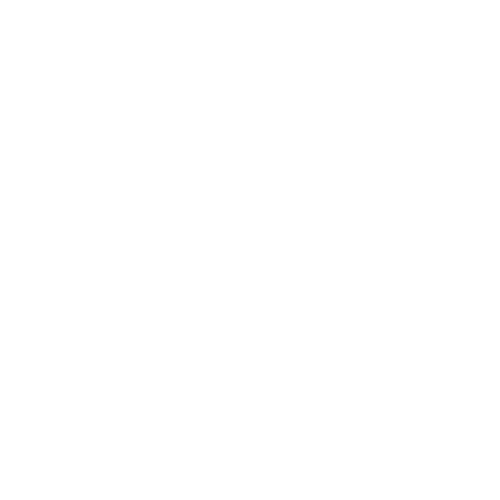

NameError: name 'Wmys' is not defined

In [180]:
plt.figure(figsize=(2.5,2.5))
data = np.concatenate((np.mean(Wmys,0),np.mean(Wmxs,0)[0:1]),axis=0)
mx = np.max(np.abs(data))
plt.imshow(data,cmap='bwr',vmin=-mx,vmax=mx)
plt.xticks(np.arange(4),lbls)
plt.yticks(np.arange(5),lbls+['L4 PC'])
plt.ylim(4.5,-0.5)
plt.colorbar()
plt.xlabel('postsynaptic')
plt.ylabel('presynaptic')
plt.tight_layout()
# plt.savefig('figures/Wmy_extended_heatmap.eps')

<IPython.core.display.Javascript object>


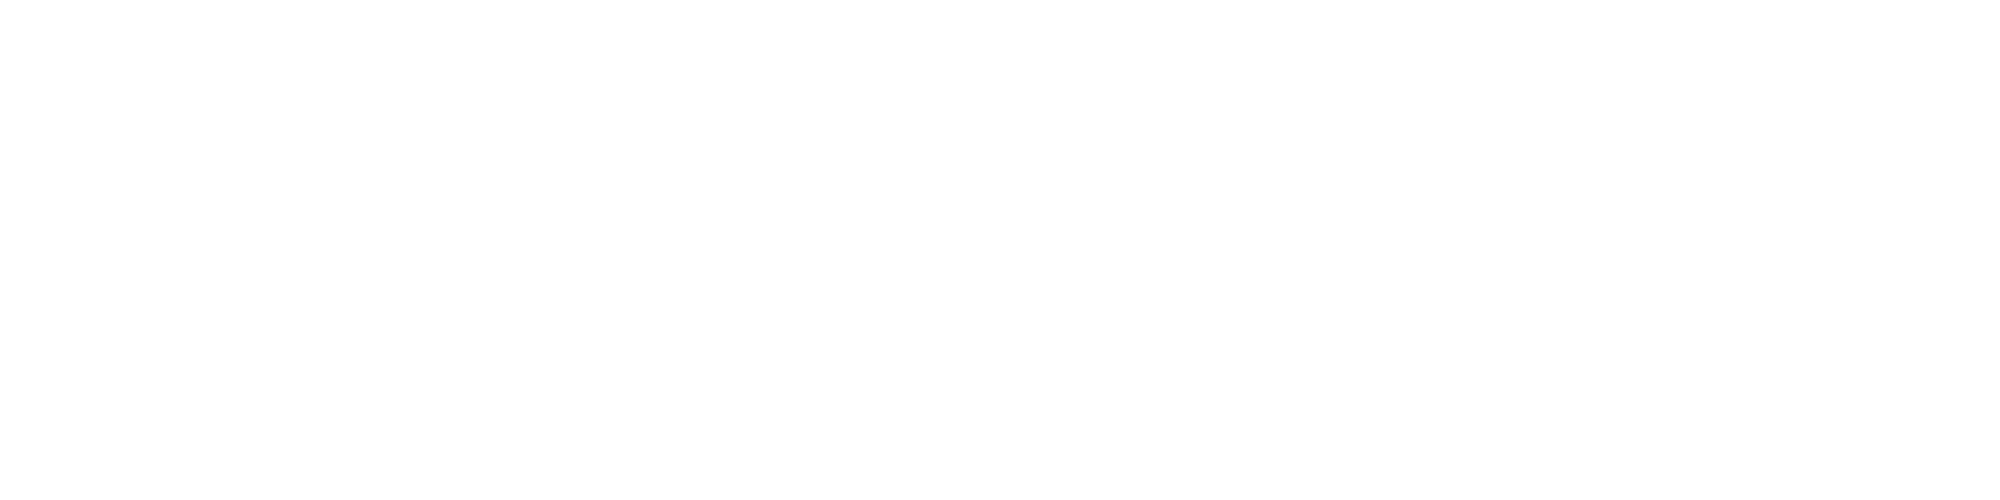

NameError: name 'W0ys' is not defined

In [181]:
lbls = ['PC','SST','VIP','PV']
plt.figure(figsize=(10,2.5))
for iws,ws in enumerate([[W0ys,W0xs],[W1ys,W1xs],[W2ys,W2xs],[W3ys,W3xs]]):
    plt.subplot(1,4,iws+1)
    data = np.concatenate((ws[0][lkat],ws[1][lkat]),axis=1)
#     data = np.concatenate((np.mean(ws[0][lkat],0),np.mean(ws[1][lkat],0)),axis=0)
    mx = np.max(np.abs(data))
    plt.imshow(np.mean(data,0),cmap='bwr',vmin=-mx,vmax=mx)
    plt.xticks(np.arange(4),lbls)
    plt.yticks(np.arange(6),lbls+['L4 PC','bias'])
    plt.ylim(5.5,-0.5)
    plt.colorbar()
    plt.xlabel('postsynaptic')
    plt.ylabel('presynaptic')
    plt.tight_layout()
    # plt.savefig('figures/Wmy_very_extended_heatmap.eps')

<IPython.core.display.Javascript object>


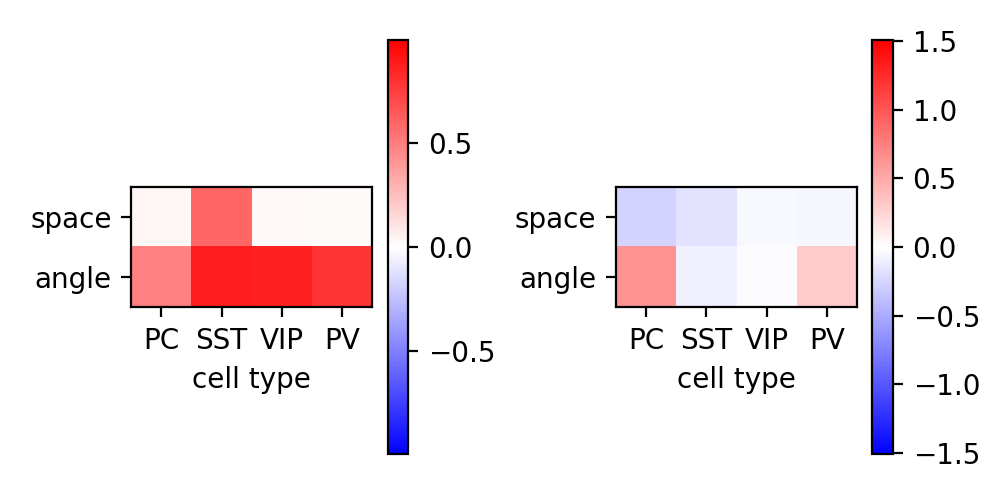

In [538]:
lbls = ['PC','SST','VIP','PV']
plt.figure(figsize=(5,2.5))
for iws,ws in enumerate([[K0s,T0s],[K1s,T1s]]):#,[K2s,T2s],[K3s,T3s]]):
    plt.subplot(1,2,iws+1)
    data = np.concatenate((ws[0][lkat][:,np.newaxis,:],ws[1][lkat][:,np.newaxis,:]),axis=1)
#     data = np.concatenate((np.mean(ws[0][lkat],0),np.mean(ws[1][lkat],0)),axis=0)
    mx = np.max(np.abs(data))
    plt.imshow(np.mean(data,0),cmap='bwr',vmin=-mx,vmax=mx)
    plt.yticks(np.arange(2),['space','angle'])
    plt.xticks(np.arange(4),lbls)#+['L4 PC','bias'])
    plt.xlim(-0.5,3.5)
    plt.ylim(1.5,-0.5)
    plt.colorbar()
#     plt.xlabel('postsynaptic')
    plt.xlabel('cell type')
    plt.tight_layout()
    # plt.savefig('figures/Wmy_very_extended_heatmap.eps')

<IPython.core.display.Javascript object>


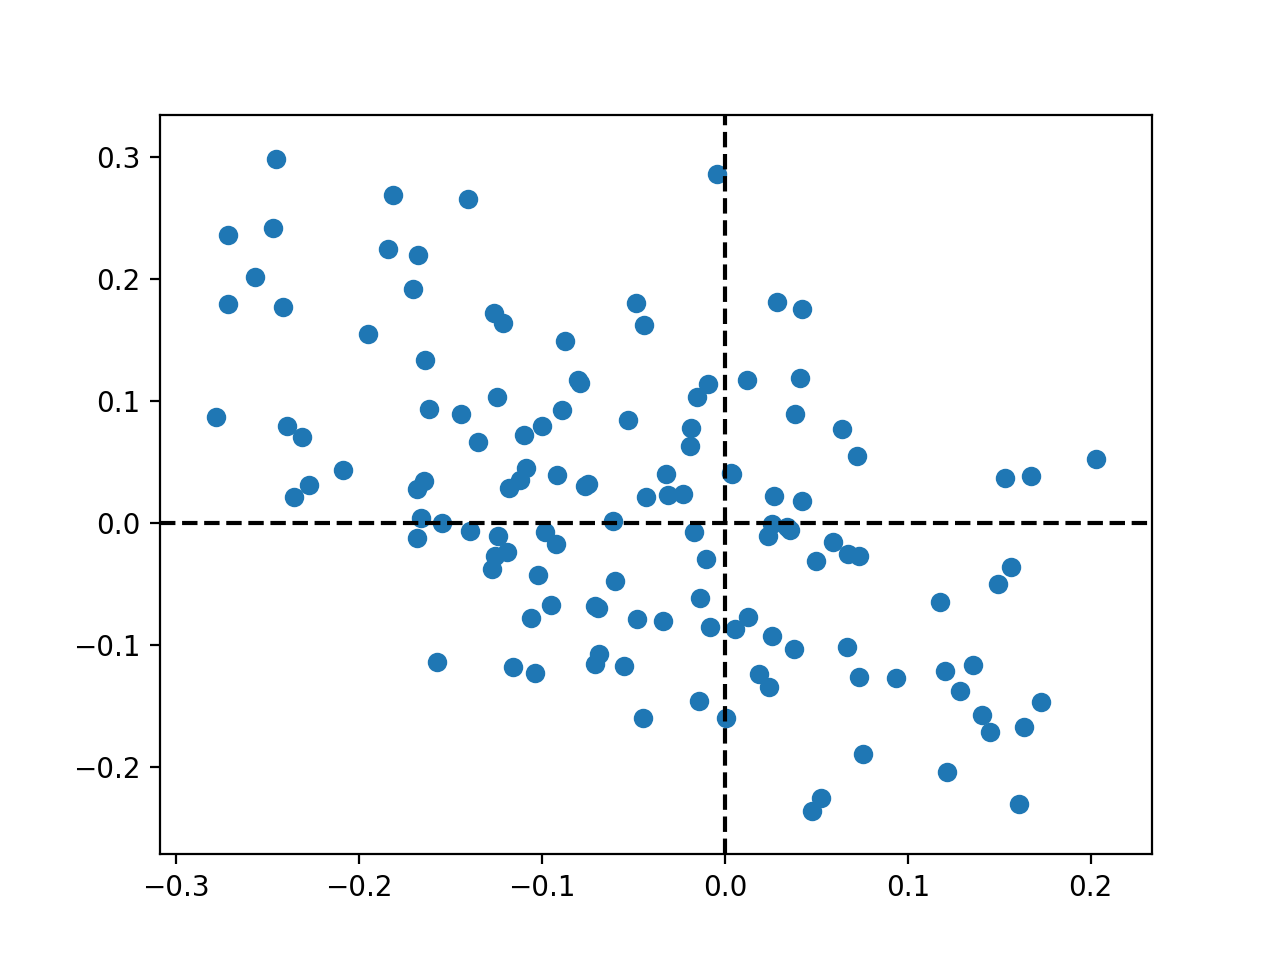

-0.5375051402427432


In [539]:
plt.figure()
x,y = W1ys[lkat,0,1],W1ys[lkat,2,1]
plt.scatter(x,y)
print(np.corrcoef(x,y)[0,1])
plt.axhline(0,c='k',linestyle='dashed')
plt.axvline(0,c='k',linestyle='dashed')

<IPython.core.display.Javascript object>


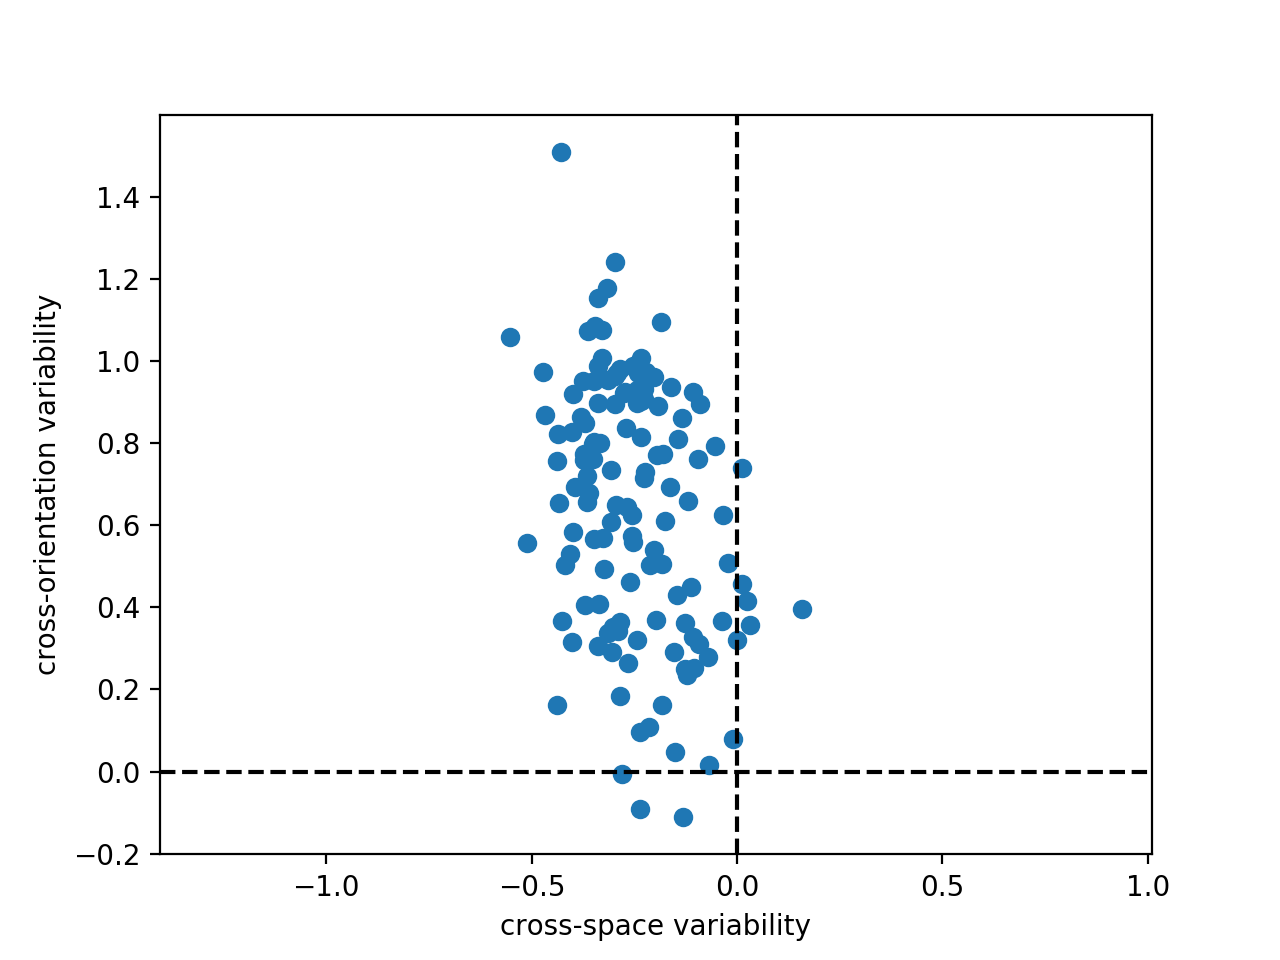

-0.3459985238975591


Text(0, 0.5, 'cross-orientation variability')

In [540]:
plt.figure()
x,y = K1s[lkat,0],T1s[lkat,0]
plt.scatter(x,y)
print(np.corrcoef(x,y)[0,1])
plt.axhline(0,c='k',linestyle='dashed')
plt.axvline(0,c='k',linestyle='dashed')
plt.axis('equal')
plt.xlabel('cross-space variability')
plt.ylabel('cross-orientation variability')

<IPython.core.display.Javascript object>


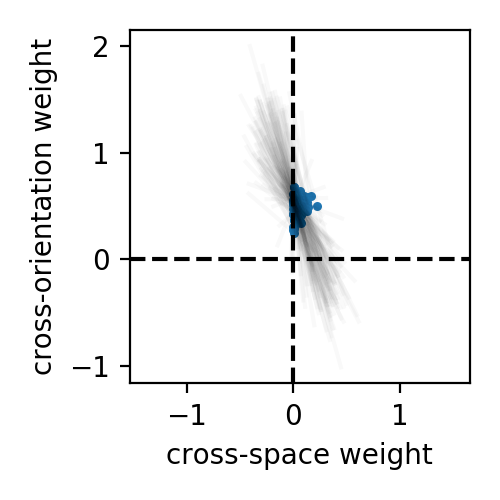

0.9999999999999999


<IPython.core.display.Javascript object>


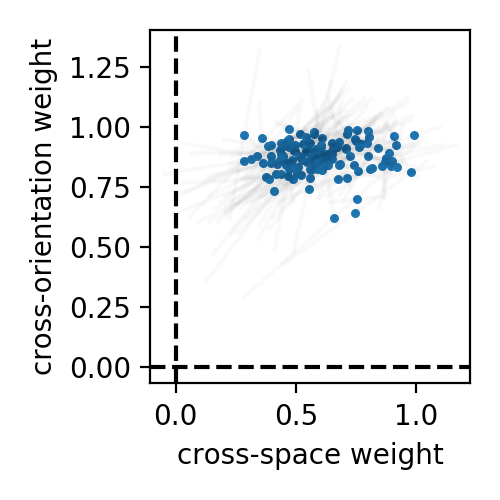

-1.0


In [552]:
for icelltype in [0,1]:
    plt.figure(figsize=(2.5,2.5))
    x = K0s[lkat,icelltype]
    y = T0s[lkat,icelltype]
    plt.scatter(x,y,s=5)
    x = np.concatenate(((K0s[lkat,icelltype]-K1s[lkat,icelltype])[:,np.newaxis],(K0s[lkat,icelltype]+K1s[lkat,icelltype])[:,np.newaxis]),axis=1)
    y = np.concatenate(((T0s[lkat,icelltype]-T1s[lkat,icelltype])[:,np.newaxis],(T0s[lkat,icelltype]+T1s[lkat,icelltype])[:,np.newaxis]),axis=1)
    plt.plot(x.T,y.T,alpha=0.025,c='k')
    print(np.corrcoef(x,y)[0,1])
    plt.axhline(0,c='k',linestyle='dashed')
    plt.axvline(0,c='k',linestyle='dashed')
    plt.axis('equal')
    plt.xlabel('cross-space weight')
    plt.ylabel('cross-orientation weight')
    plt.tight_layout()
    plt.savefig('figures/%s_ks_ts.jpg'%lbls[icelltype],dpi=300)